# Case Study: How Does a Bike-Share Navigate Speedy Success?

## Guiding Questions of Analysis?

1. How do annual members and casual riders use Cyclistic bikes differently?

## Data Gathering

The data gathered for this analysis is sourced from the __[publicly open dataset](https://divvy-tripdata.s3.amazonaws.com/index.html)__ which is provided by the Company **Cyclistic** under the following __[Data Licence Agreement](https://ride.divvybikes.com/data-license-agreement)__.



In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as ptly_go
import plotly.offline as ptly_off
import matplotlib.pyplot as plt
import matplotlib.ticker as mat_tick
from pathlib import Path
import math
import seaborn as sns
import locale
import datetime
from IPython.display import Markdown as md
from glob import glob
import heapq
import plotly.io as pio

pio.renderers.default = "notebook"
ptly_off.init_notebook_mode()

locale.setlocale(locale.LC_NUMERIC, 'de_DE')
locale.setlocale(locale.LC_TIME, 'en_US')
%matplotlib inline

In [2]:
# IMPORTING DATA
csv_list = glob('*-tripdata.csv', root_dir="./../raw_data/")

dfs = [
    pd.read_csv(f'./../raw_data/{filename}', index_col = None, parse_dates = ['started_at','ended_at'],
                dtype={'rideable_type': 'category', 'casual_member': 'category'})
    for filename in csv_list
]

df = pd.concat(dfs)


## Data Cleaning

Start by Cleaning the data where there are any N/A values as well as rides that start and end at the exact coordinate values.

In [3]:
# DROP NaN RIDES
# DROP ROWS IF STATIONS = NaN AND START + END LAT/LONG VALUES ARE SAME
df_cleaned = df.dropna(axis=0, how='any', 
            subset=['start_station_name','start_station_id', 'end_station_name', 'end_station_id'],
            inplace = False)

df_cleaned = df_cleaned.loc[(df_cleaned['start_lat'] != df_cleaned['end_lat']) & 
                            (df_cleaned['start_lng'] != df_cleaned['end_lng'])]

md(f"""Rows drecreased by **{locale.format_string('%d', df.shape[0]-df_cleaned.shape[0], grouping=True)}** 
   from {locale.format_string('%d', df.shape[0], grouping = True)} to {locale.format_string('%d', df_cleaned.shape[0], grouping=True)}.""")


Rows drecreased by **1.507.429** 
   from 5.901.463 to 4.394.034.

## Data Preparation

* Adding formatted columns (hour of ride, weekday, month) to further slice data
* Calculating distance travlled (point-to-point)

In [4]:
# CALCULATING TIME RELATED DATA
df_cleaned['hour_of_ride'] = df_cleaned['started_at'].dt.hour
df_cleaned['day_of_ride'] = pd.Categorical(df_cleaned['started_at'].dt.day_name(),
        categories= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
df_cleaned['month_of_ride'] = pd.Categorical(df_cleaned['started_at'].dt.month_name(),
                    categories= ['August', 'September', 'October', 'November', 'December',
                    'January', 'February', 'March', 'April', 'May', 'June', 'July'])
df_cleaned['year_of_ride'] = df_cleaned['started_at'].dt.year

# CALCULATING RIDE TIMES
df_cleaned['length_of_ride_tdelta'] = df_cleaned['ended_at'] - df_cleaned['started_at']
df_cleaned['length_of_ride_s'] = df_cleaned['length_of_ride_tdelta'].apply(lambda x: datetime.timedelta.total_seconds(x))


### Calculating the travel distane (Point-to-Point)

#### The haversine formula or haversine distance

To calculate the distance on a sphere we can use the formula:
$$ d = r * acos ( sin(\Phi_{1}) * sin(\Phi_{2}) + cos(\Phi_{1}) * cos(\Phi_{1}) * cos(\Delta\lambda)) $$


Where:<br>
r = radius of Sphere, Earth = ~6.371km <br>
$\Phi_{1}$ = Latitude of start point <br>
$\Phi_{2}$ = Latitude of end point <br>
$\Delta\lambda$ = Delta/Difference of longitude between end point and start point

Source: __[movable-type.co.uk](https://www.movable-type.co.uk/scripts/latlong.html)__

In [5]:
# DISTANCE Formula
def calc_sphere_dist(start_lat:float, start_lng:float, end_lat:float, end_lng:float, R:int|float=6371000):
    """Calculate distance between two spherical points using Haversine distane.
    Takes coordinates in as angles and returns distance as default for Earth in m. 

    Args:
        start_lat (float): Latitude Point 1 in angle
        start_lng (float): Longitude Point 1 in angle
        end_lat (float): Latitude Point 2 in angle
        end_lng (float): Longitude Point 2 in angle
        R (int or float, optional): Radius of the sphere. Defaults to 6371000 (Earth radius in m).

    Returns:
        float: Returns distance as default for Earth in [m]. 
    """ 
    # CONVERT TO RADIANS
    start_lat_deg = math.radians(start_lat)
    start_lng_deg = math.radians(start_lng)
    end_lat_deg = math.radians(end_lat)
    end_lng_deg = math.radians(end_lng)
    
    # APPLY DISTANCE FORMULA LIKE OUTLINED ABOVE
    d = R * math.acos(
        math.sin(start_lat_deg) * math.sin(end_lat_deg) +
        math.cos(start_lat_deg) * math.cos(end_lat_deg) * math.cos(end_lng_deg - start_lng_deg)
    )

    return d

In [6]:
# CALCULATE RIDE DISTANCE (POINT-TO-POINT)
df_cleaned['dist_ride'] = df_cleaned.apply(lambda x: 
    calc_sphere_dist(x['start_lat'], x['start_lng'], x['end_lat'], x['end_lng']), axis = 1)

## Data Analysis

Get a feel for the dataset with calculating some high-level statistics:
* Average, Median, Max and Min for the ride time as well as the ride distance
* most commonly observed time of day, weekday and month of ride

In [7]:
# FUNCTION TO TURN TIMEDELTA INTO A TIME STRING (NOT BUILT IN FUNCTION)
# seen on https://stackoverflow.com/questions/8906926/formatting-timedelta-objects
from string import Template

def strfdelta(tdelta:datetime.timedelta, fmt:str="%H:%M:%S"):
    """Format a timedelta object into a time string like strf function

    Args:
        tdelta (timedelta object): Timedelta object to be converted to a time string
        fmt (str, optional): Format string to specify desired output format. Default: "%H:%M:%S"

    Returns:
        str: Returns string in timeformat.
    """ 
    
    class DeltaTemplate(Template):
        delimiter = "%"
        
    d = {"D": tdelta.days}
    d["H"], rem = divmod(tdelta.seconds, 3600)
    d["H"] = str(d["H"]).zfill(2)
    d["M"], d["S"] = divmod(rem, 60)
    d["M"] = str(d["M"]).zfill(2)
    d["S"] = str(d["S"]).zfill(2)
    t = DeltaTemplate(fmt)
    return t.substitute(**d)

### High Level Stats - 1

In [8]:
# CALCULATE DESCRIPTIVE STATISTICS
avg_ride_timedelta = strfdelta(df_cleaned['length_of_ride_tdelta'].mean(), '%H:%M:%S')
median_ride_timedelta = strfdelta(df_cleaned['length_of_ride_tdelta'].median(), '%H:%M:%S')
max_ride_timedelta = strfdelta(df_cleaned['length_of_ride_tdelta'].max(), '%D days %H:%M:%S')
min_ride_timedelta = strfdelta(df_cleaned['length_of_ride_tdelta'].min(), '%D days %H:%M:%S')

avg_ride_dist = locale.format_string('%d', round(df_cleaned['dist_ride'].mean(), 2), grouping=True)
median_ride_dist = locale.format_string('%d',round(df_cleaned['dist_ride'].median(), 2), grouping=True)
max_ride_dist = locale.format_string('%d',round(df_cleaned['dist_ride'].max(), 2), grouping=True)
min_ride_dist = locale.format_string('%d',round(df_cleaned['dist_ride'].min(), 2), grouping=True)

most_common_hour = df_cleaned['hour_of_ride'].mode()[0]
most_common_day = df_cleaned['day_of_ride'].mode()[0]
most_common_month = df_cleaned['month_of_ride'].mode()[0]
most_common_start_station = df_cleaned['start_station_name'].mode()[0]
most_common_end_station = df_cleaned['end_station_name'].mode()[0]

dist_time_corr = df_cleaned['length_of_ride_s'].corr(df_cleaned['dist_ride'])

df_sorted = df_cleaned.sort_values(by=['dist_ride'], ascending=False)

count_rides = df_cleaned['ride_id'].count()

In [9]:
md(f"""The high-level statistics shows the following results:<br>
Number of observations: **{locale.format_string('%d', count_rides, grouping = True)}**
<br>
Correlation between time and distance is:
r = **{round(dist_time_corr,5)}**
<br>

| Variable | Average | Median | Max | Min | 
|----------| :-: | :-: | :-: | :-: |
| ride length [t] | {avg_ride_timedelta} | {median_ride_timedelta} | {max_ride_timedelta} | {min_ride_timedelta} |
| ride distance [m] | {avg_ride_dist} | {median_ride_dist} | {max_ride_dist} | {min_ride_dist} | 

<br>

| Variable | Mode (most common) |
| --- | :-: |
| hour of ride | {most_common_hour} |
| day of ride | {most_common_day} |
| month of ride | {most_common_month} |
| start station | {most_common_start_station} |
| end station | {most_common_end_station} |



<br>
The data shows that there is a Min value of ride time that is negative, indicating that the end time was before the start time. The Min value of ride dist also shows 0 distance travelled (although that was supposed to be filtered out by same Lat + Long before).

Also there seems to be a stark outlier with over {locale. format_string('%d', round(int(max_ride_dist.replace(".",""))/1000,1), grouping=True)}km travelled. On further inspection this was done with an electrik bike however the length of the bike ride was too short to make sense. Add new rule to filter out rides > 200km

Those data points are invalid and need to be filtered out before proceeding with more analysis.
 """)

The high-level statistics shows the following results:<br>
Number of observations: **4.394.034**
<br>
Correlation between time and distance is:
r = **0.09955**
<br>

| Variable | Average | Median | Max | Min | 
|----------| :-: | :-: | :-: | :-: |
| ride length [t] | 00:17:39 | 00:11:06 | 28 days 21:49:10 | -1 days 21:50:55 |
| ride distance [m] | 2.221 | 1.667 | 1.189.522 | 0 | 

<br>

| Variable | Mode (most common) |
| --- | :-: |
| hour of ride | 17 |
| day of ride | Saturday |
| month of ride | August |
| start station | Streeter Dr & Grand Ave |
| end station | Streeter Dr & Grand Ave |



<br>
The data shows that there is a Min value of ride time that is negative, indicating that the end time was before the start time. The Min value of ride dist also shows 0 distance travelled (although that was supposed to be filtered out by same Lat + Long before).

Also there seems to be a stark outlier with over 1.189km travelled. On further inspection this was done with an electrik bike however the length of the bike ride was too short to make sense. Add new rule to filter out rides > 200km

Those data points are invalid and need to be filtered out before proceeding with more analysis.
 

### Data Cleaning - Step 1

Filter out rows with the following conditios:
* length of travel as timedelta < 0 (negative) OR
* ride distane in m is <= 0 OR
* ride distance in m is > 200.000

In [10]:
# MORE CLEANING ACCORDING TO CRITERIA ABOVE
df_cleaned_v2 = df_cleaned.loc[(df_cleaned['dist_ride'] > 0) & 
                               (df_cleaned['length_of_ride_tdelta']>datetime.timedelta(seconds=1)) &
                               (df_cleaned['dist_ride'] < 200000)]

In [11]:
md(f"""Rows drecreased by **{locale.format_string('%d', df_cleaned.shape[0]-df_cleaned_v2.shape[0], grouping = True)}** 
   from {locale.format_string('%d', df_cleaned.shape[0], grouping = True)} 
   to {locale.format_string('%d', df_cleaned_v2.shape[0], grouping = True)}.""")

Rows drecreased by **315** 
   from 4.394.034 
   to 4.393.719.

### High Level Stats - 2

In [12]:
# RE-CALCULATE DESCRIPTIVE STAISTICS
avg_ride_timedelta_v2 = strfdelta(df_cleaned_v2['length_of_ride_tdelta'].mean(), '%H:%M:%S')
median_ride_timedelta_v2 = strfdelta(df_cleaned_v2['length_of_ride_tdelta'].median(), '%H:%M:%S')
max_ride_timedelta_v2 = strfdelta(df_cleaned_v2['length_of_ride_tdelta'].max(), '%D days %H:%M:%S')
min_ride_timedelta_v2 = strfdelta(df_cleaned_v2['length_of_ride_tdelta'].min(), '%D days %H:%M:%S')

avg_ride_dist_v2 = locale.format_string('%d', round(df_cleaned_v2['dist_ride'].mean(), 2), grouping=True)
median_ride_dist_v2 = locale.format_string('%d',round(df_cleaned_v2['dist_ride'].median(), 2), grouping=True)
max_ride_dist_v2 = locale.format_string('%d',round(df_cleaned_v2['dist_ride'].max(), 2), grouping=True)
min_ride_dist_v2 = locale.format_string('%d',round(df_cleaned_v2['dist_ride'].min(), 2), grouping=True)

most_common_hour_v2 = df_cleaned_v2['hour_of_ride'].mode()[0]
most_common_day_v2 = df_cleaned_v2['day_of_ride'].mode()[0]
most_common_month_v2 = df_cleaned_v2['month_of_ride'].mode()[0]
most_common_start_station_v2 = df_cleaned_v2['start_station_name'].mode()[0]
most_common_end_station_v2 = df_cleaned_v2['end_station_name'].mode()[0]

dist_time_corr_v2 = df_cleaned_v2['length_of_ride_s'].corr(df_cleaned_v2['dist_ride'])

df_max_ride_dist = df_cleaned_v2.loc[(df_cleaned_v2['dist_ride'] == df_cleaned_v2['dist_ride'].max())]

count_rides_v2 = df_cleaned_v2['ride_id'].count()

In [13]:
md(f"""The high-level statistics shows the following results:<br>
Number of observations: {locale.format_string('%d', count_rides_v2, grouping = True)}
<br>
Correlation between time and distance is:
r = {round(dist_time_corr_v2,5)} 

| Variable | Average | Median | Max | Min | 
|----------| :-: | :-: | :-: | :-: |
| ride length [t] | {avg_ride_timedelta_v2} | {median_ride_timedelta_v2} | {max_ride_timedelta_v2} | {min_ride_timedelta_v2} |
| ride distance [m] | {avg_ride_dist_v2} | {median_ride_dist_v2} | {max_ride_dist_v2} | {min_ride_dist_v2} | 

<br>

| Time of ride | Mode (most common) |
| --- | :-: |
| hour of ride | {most_common_hour_v2} |
| day of ride | {most_common_day_v2} |
| month of ride | {most_common_month_v2} |
| start station | {most_common_start_station_v2} |
| end station | {most_common_end_station_v2} |

Although there all rides with same start coordinates have been filtered out, there are still rides with no or very little
distance travelled. Also there are rides that only last a few seconds. To get a beter understanding of "real" rides, e.g. rides
that are used to travel somewhere and are not "accidentally" unlocked, a new rule will be applied: rides have to be farther than 100m
and longer than 1 min.
 """)


The high-level statistics shows the following results:<br>
Number of observations: 4.393.719
<br>
Correlation between time and distance is:
r = 0.10411 

| Variable | Average | Median | Max | Min | 
|----------| :-: | :-: | :-: | :-: |
| ride length [t] | 00:17:39 | 00:11:06 | 28 days 21:49:10 | 0 days 00:00:02 |
| ride distance [m] | 2.221 | 1.667 | 31.906 | 0 | 

<br>

| Time of ride | Mode (most common) |
| --- | :-: |
| hour of ride | 17 |
| day of ride | Saturday |
| month of ride | August |
| start station | Streeter Dr & Grand Ave |
| end station | Streeter Dr & Grand Ave |

Although there all rides with same start coordinates have been filtered out, there are still rides with no or very little
distance travelled. Also there are rides that only last a few seconds. To get a beter understanding of "real" rides, e.g. rides
that are used to travel somewhere and are not "accidentally" unlocked, a new rule will be applied: rides have to be farther than 100m
and longer than 1 min.
 

### Data Cleaning - Step 2

In [14]:
# NARROWING DOWN DATA SET TO MATCH ACTUAL DEMAND DIST > 100m and RIDE TIME > 1 MIN
df_cleaned_v3 = df_cleaned_v2.loc[(df_cleaned_v2['dist_ride'] > 100) & 
                               (df_cleaned_v2['length_of_ride_tdelta']>datetime.timedelta(minutes=1))]


In [15]:
md(f"""Rows drecreased by **{locale.format_string('%d', df_cleaned_v2.shape[0]-df_cleaned_v3.shape[0], grouping = True)}** 
from {locale.format_string('%d', df_cleaned_v2.shape[0], grouping = True)} 
to {locale.format_string('%d', df_cleaned_v3.shape[0], grouping = True)}.<br>
   
In total Rows decreased by **{locale.format_string('%d', df.shape[0]-df_cleaned_v3.shape[0], grouping = True)}** from original dataset.
""")

Rows drecreased by **78.917** 
from 4.393.719 
to 4.314.802.<br>
   
In total Rows decreased by **1.586.661** from original dataset.


In [16]:
# CREATE SUBCATEGORY FOR DIST TRAVLLED FROM ULTRA-SHORT TO EXTRA-LONG
def map_distance(x):
    map = {'< 500': 'Short', '< 1000': 'Short-Medium', '< 2500': 'Medium',
           '< 5000': 'Medium-Long', '<10000': 'Long', '>= 10000': 'Extra-Long'}
    for key, value in map.items():
        if eval(f'{x} {key}'):
            return value
            break
            
df_cleaned_v3['dist_class'] = pd.Categorical(df_cleaned_v3['dist_ride'].apply(lambda x:map_distance(x)),
        categories=['Short','Short-Medium', 'Medium', 'Medium-Long', 'Long', 'Extra-Long'])

C:\Users\kemke\AppData\Local\Temp\ipykernel_16356\784846940.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
# EpxORTING CLEANED DATA TO CSV
df_cleaned_v3.to_csv('.\..\data\cleaned_data.csv', float_format="%.2f", index=False)


#### IMPROT DF for quick restart and PURGE OBSOLETE DATA

In [18]:
# import df_cleaned_v3
if 'df_cleaned_v3' not in globals():
    import numpy as np
    import pandas as pd
    import plotly.express as px
    import plotly.graph_objects as ptly_go
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mat_tick
    from pathlib import Path
    import math
    import seaborn as sns
    import heapq
    import nbformat as nbf
    import locale
    import datetime
    from IPython.display import Markdown as md

    locale.setlocale(locale.LC_NUMERIC, 'de_DE')
    locale.setlocale(locale.LC_TIME, 'en_US')
    %matplotlib inline
    
    cols = ['ride_id', 'rideable_type', 'started_at', 'ended_at', 'start_station_name', 'start_station_id',
        'end_station_name', 'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_casual',
        'hour_of_ride', 'day_of_ride', 'month_of_ride', 'year_of_ride', 'length_of_ride_tdelta', 'length_of_ride_s',
        'dist_ride', 'dist_class']

    df_cleaned_v3 = pd.read_csv('./data/cleaned_data.csv',
            parse_dates = ['started_at','ended_at','length_of_ride_tdelta'], usecols=cols, dtype={
        # 'month_of_ride': 'category',
        # 'day_of_ride': 'category',
        # 'rideable_type': 'category',
        'start_lat': 'float64',
        'start_lng': 'float64',
        'end_lat': 'float64',
        'end_lng': 'float64',
        # 'member_casual': 'category',
        # 'ride_timedelta': 'timedelta64[ns]',
        'length_of_ride_s': 'float64',
        'dist_ride': 'float64',
        # 'dist_class': 'catgory',
        })
    
    df_cleaned_v3['length_of_ride_tdelta'] = pd.to_timedelta(df_cleaned_v3['length_of_ride_tdelta'])
    for col in ['month_of_ride', 'day_of_ride', 'rideable_type', 'member_casual', 'dist_class']:
        df_cleaned_v3[col] = df_cleaned_v3[col].astype('category')
        
    df_cleaned_v3['day_of_ride'] = pd.Categorical(df_cleaned_v3['started_at'].dt.day_name(),
        categories= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
else:
    globals().pop('dfs', None);
    globals().pop('df_sorted', None);
    globals().pop('df', None);
    globals().pop('df_cleaned', None);
    globals().pop('df_cleaned_v2', None);

df_cleaned_v3['day_of_ride'] = pd.Categorical(df_cleaned_v3['day_of_ride'],
        categories= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

df_cleaned_v3['month_of_ride'] = pd.Categorical(df_cleaned_v3['month_of_ride'],
                    categories= ['August', 'September', 'October', 'November', 'December',
                    'January', 'February', 'March', 'April', 'May', 'June', 'July'])

df_cleaned_v3['dist_class'] = pd.Categorical(df_cleaned_v3['dist_class'],
        categories=['Short','Short-Medium', 'Medium', 'Medium-Long', 'Long', 'Extra-Long'])

df_cleaned_v3['rideable_type'] = df_cleaned_v3['rideable_type'].apply(lambda x: x.replace('_',' '))
df_cleaned_v3[['member_casual', 'rideable_type']] = df_cleaned_v3[['member_casual', 'rideable_type']] \
    .astype(str).apply(lambda col: col.str.title())


# FUNCTION TO TURN TIMEDELTA INTO A TIME STRING (NOT BUILT IN FUNCTION)
# seen on https://stackoverflow.com/questions/8906926/formatting-timedelta-objects
from string import Template
class DeltaTemplate(Template):
    delimiter = "%"

def strfdelta(tdelta, fmt):
    d = {"D": tdelta.days}
    d["H"], rem = divmod(tdelta.seconds, 3600)
    d["H"] = str(d["H"]).zfill(2)
    d["M"], d["S"] = divmod(rem, 60)
    d["M"] = str(d["M"]).zfill(2)
    d["S"] = str(d["S"]).zfill(2)
    t = DeltaTemplate(fmt)
    return t.substitute(**d)   

### High Level Stats - 3

In [19]:
# RE-CALCULATE DESCRIPTIVE STAISTICS
avg_ride_timedelta_v3 = strfdelta(df_cleaned_v3['length_of_ride_tdelta'].mean(), '%H:%M:%S')
median_ride_timedelta_v3 = strfdelta(df_cleaned_v3['length_of_ride_tdelta'].median(), '%H:%M:%S')
max_ride_timedelta_v3 = strfdelta(df_cleaned_v3['length_of_ride_tdelta'].max(), '%D days %H:%M:%S')
min_ride_timedelta_v3 = strfdelta(df_cleaned_v3['length_of_ride_tdelta'].min(), '%D days %H:%M:%S')

avg_ride_dist_v3 = locale.format_string('%d', round(df_cleaned_v3['dist_ride'].mean(), 2), grouping=True)
median_ride_dist_v3 = locale.format_string('%d',round(df_cleaned_v3['dist_ride'].median(), 2), grouping=True)
max_ride_dist_v3 = locale.format_string('%d',round(df_cleaned_v3['dist_ride'].max(), 2), grouping=True)
min_ride_dist_v3 = locale.format_string('%d',round(df_cleaned_v3['dist_ride'].min(), 2), grouping=True)

most_common_hour_v3 = df_cleaned_v3['hour_of_ride'].mode()[0]
most_common_day_v3 = df_cleaned_v3['day_of_ride'].mode()[0]
most_common_month_v3 = df_cleaned_v3['month_of_ride'].mode()[0]
most_common_start_station_v3 = df_cleaned_v3['start_station_name'].mode()[0]
most_common_end_station_v3 = df_cleaned_v3['end_station_name'].mode()[0]

dist_time_corr_v3 = df_cleaned_v3['length_of_ride_s'].corr(df_cleaned_v3['dist_ride'])

count_rides_v3= df_cleaned_v3['ride_id'].count()

In [20]:
md(f"""The high-level statistics shows the following results:
<br>
Number of observations: **{locale.format_string('%d', count_rides_v3, grouping = True)}**
<br>
Correlation between time and distance is:
r = **{round(dist_time_corr_v3,5)}**
   
| Variable | Average | Median | Max | Min | 
|----------| :-: | :-: | :-: | :-: |
| ride length [t] | {avg_ride_timedelta_v3} | {median_ride_timedelta_v3} | {max_ride_timedelta_v3} | {min_ride_timedelta_v3} |
| ride distance [m] | {avg_ride_dist_v3} | {median_ride_dist_v3} | {max_ride_dist_v3} | {min_ride_dist_v3} | 

<br>

| Time of ride | Mode (most common) |
| --- | :-: |
| hour of ride | {most_common_hour_v3} |
| day of ride | {most_common_day_v3} |
| month of ride | {most_common_month_v3} | 
| start station | {most_common_start_station_v3} |
| end station | {most_common_end_station_v3} |
 """)

The high-level statistics shows the following results:
<br>
Number of observations: **4.314.802**
<br>
Correlation between time and distance is:
r = **0.10584**
   
| Variable | Average | Median | Max | Min | 
|----------| :-: | :-: | :-: | :-: |
| ride length [t] | 00:17:38 | 00:11:09 | 28 days 21:49:10 | 0 days 00:01:01 |
| ride distance [m] | 2.261 | 1.697 | 31.906 | 100 | 

<br>

| Time of ride | Mode (most common) |
| --- | :-: |
| hour of ride | 17 |
| day of ride | Saturday |
| month of ride | August | 
| start station | Streeter Dr & Grand Ave |
| end station | Streeter Dr & Grand Ave |
 

## Deep Dive - Statistics via Pivot

Taking a deeper look into the cleaned data and aggregating the data into different pivots

### Pivot - Member-Type

In [21]:
# GROUPING STATISTICS
df_groupby_member = df_cleaned_v3.groupby('member_casual')\
    .apply(lambda df: pd.Series({
    'count_of_rides': locale.format_string('%d', df['ride_id'].count(), grouping = True),
    'r' : round(df['length_of_ride_s'].corr(df['dist_ride']), 5),
    
    'common_hour': df['hour_of_ride'].mode()[0],
    'most_common_day': df['day_of_ride'].mode()[0],
    'most_common_month': df['month_of_ride'].mode()[0],
        
    'avg_time': strfdelta(df['length_of_ride_tdelta'].mean(), '%H:%M:%S'),
    'median_time': strfdelta(df['length_of_ride_tdelta'].median(), '%H:%M:%S'),
    'std_time': strfdelta(df['length_of_ride_tdelta'].std(), '%H:%M:%S'),
    'max_time': df['length_of_ride_tdelta'].max(),
    'min_time': strfdelta(df['length_of_ride_tdelta'].min(), '%H:%M:%S'),
    
    'avg_dist': round(df['dist_ride'].mean(), 0),
    'median_dist': round(df['dist_ride'].median(), 0),
    'std_dist': round(df['dist_ride'].std(), 0),
    'max_dist': round(df['dist_ride'].max(), 0),
    'min_dist': round(df['dist_ride'].min(), 0),
    }))

df_groupby_member

count_of_rides        r  common_hour most_common_day  \
member_casual                                                        
Casual             1.753.742  0.07688           17        Saturday   
Member             2.561.060  0.41390           17         Tuesday   

              most_common_month  avg_time median_time  std_time  \
member_casual                                                     
Casual                   August  00:25:03    00:14:45  02:06:47   
Member                   August  00:12:33    00:09:15  00:17:12   

                      max_time  min_time  avg_dist  median_dist  std_dist  \
member_casual                                                               
Casual        28 days 21:49:10  00:01:01    2437.0       1884.0    1934.0   
Member         1 days 00:52:55  00:01:01    2142.0       1582.0    1776.0   

               max_dist  min_dist  
member_casual                      
Casual          31906.0     100.0  
Member          27488.0     100.0

### Pivot - Rideable-Type

In [22]:
# GROUPING STATISTICS
df_groupby_ride = df_cleaned_v3.groupby('rideable_type') \
    .apply(lambda df: pd.Series({
    'count_of_rides': locale.format_string('%d', df['ride_id'].count(), grouping = True),
    'r' : round(df['length_of_ride_s'].corr(df['dist_ride']), 5),
    
    'common_hour': df['hour_of_ride'].mode()[0],
    'most_common_day': df['day_of_ride'].mode()[0],
        
    'avg_time': strfdelta(df['length_of_ride_tdelta'].mean(), '%H:%M:%S'),
    'median_time': strfdelta(df['length_of_ride_tdelta'].median(), '%H:%M:%S'),
    'std_time': strfdelta(df['length_of_ride_tdelta'].std(), '%H:%M:%S'),
    'max_time': df['length_of_ride_tdelta'].max(),
    'min_time': strfdelta(df['length_of_ride_tdelta'].min(), '%H:%M:%S'),
    
    'avg_dist': round(df['dist_ride'].mean(), 0),
    'median_dist': round(df['dist_ride'].median(), 0),
    'std_dist': round(df['dist_ride'].std(), 0),
    'max_dist': round(df['dist_ride'].max(), 0),
    'min_dist': round(df['dist_ride'].min(), 0),
    }))

df_groupby_ride    

count_of_rides        r  common_hour most_common_day  avg_time  \
rideable_type                                                                  
Classic Bike       2.863.190  0.29272           17        Saturday  00:16:47   
Docked Bike          184.788  0.04627           16        Saturday  00:55:20   
Electric Bike      1.266.824  0.46330           17        Thursday  00:14:03   

              median_time  std_time         max_time  min_time  avg_dist  \
rideable_type                                                              
Classic Bike     00:11:12  00:29:30  1 days 00:59:25  00:01:01    2137.0   
Docked Bike      00:25:51  06:15:34 28 days 21:49:10  00:01:10    2639.0   
Electric Bike    00:10:00  00:14:44  0 days 07:59:55  00:01:01    2489.0   

               median_dist  std_dist  max_dist  min_dist  
rideable_type                                             
Classic Bike        1608.0    1739.0   30186.0     102.0  
Docked Bike         1973.0    2244.0   31906.0     102.0  
Electric Bike       1899.0    1987.0   28741.0     100.0

### Pivot - Month

In [23]:
# GROUPING STATISTICS
df_groupby_month = df_cleaned_v3.groupby('month_of_ride')\
    .apply(lambda df: pd.Series({
    'count_of_rides': locale.format_string('%d', df['ride_id'].count(), grouping = True),
    'r' : round(df['length_of_ride_s'].corr(df['dist_ride']), 5),
    
    'common_hour': df['hour_of_ride'].mode()[0],
    'most_common_day': df['day_of_ride'].mode()[0],
        
    'avg_time': strfdelta(df['length_of_ride_tdelta'].mean(), '%H:%M:%S'),
    'median_time': strfdelta(df['length_of_ride_tdelta'].median(), '%H:%M:%S'),
    'std_time': strfdelta(df['length_of_ride_tdelta'].std(), '%H:%M:%S'),
    'max_time': df['length_of_ride_tdelta'].max(),
    'min_time': strfdelta(df['length_of_ride_tdelta'].min(), '%H:%M:%S'),
    
    'avg_dist': round(df['dist_ride'].mean(), 0),
    'median_dist': round(df['dist_ride'].median(), 0),
    'std_dist': round(df['dist_ride'].std(), 0),
    'max_dist': round(df['dist_ride'].max(), 0),
    'min_dist': round(df['dist_ride'].min(), 0),
    }))

df_groupby_month   

count_of_rides        r  common_hour most_common_day  avg_time  \
month_of_ride                                                                  
August               627.257  0.09377           17          Sunday  00:19:57   
September            580.808  0.08451           17        Saturday  00:19:12   
October              449.826  0.08579           17        Saturday  00:16:58   
November             242.781  0.10864           17         Tuesday  00:13:35   
December             167.342  0.06369           17        Thursday  00:13:45   
January               76.473  0.05098           17        Thursday  00:12:36   
February              84.707  0.11718           17          Monday  00:12:35   
March                202.153  0.09013           17       Wednesday  00:16:07   
April                255.224  0.22528           17        Saturday  00:15:37   
May                  462.972  0.23225           17          Monday  00:18:34   
June                 573.835  0.25961           17        Thursday  00:18:12   
July                 591.424  0.15218           17        Saturday  00:18:22   

              median_time  std_time         max_time  min_time  avg_dist  \
month_of_ride                                                              
August           00:12:37  01:33:06 28 days 21:49:10  00:01:01    2357.0   
September        00:11:59  01:53:41 22 days 19:38:32  00:01:01    2331.0   
October          00:10:33  01:40:30 28 days 06:25:01  00:01:01    2190.0   
November         00:08:51  01:08:55 13 days 08:37:49  00:01:01    2002.0   
December         00:08:34  02:10:13 21 days 02:40:33  00:01:01    1976.0   
January          00:07:48  02:43:07 20 days 07:51:06  00:01:01    1780.0   
February         00:08:04  00:58:38  7 days 13:45:58  00:01:01    1855.0   
March            00:09:38  01:37:50 23 days 20:34:04  00:01:01    2134.0   
April            00:09:48  00:36:39  5 days 05:45:58  00:01:01    2148.0   
May              00:11:54  00:37:05  7 days 10:42:58  00:01:01    2343.0   
June             00:12:08  00:32:01  4 days 15:12:52  00:01:01    2370.0   
July             00:12:03  00:54:56 22 days 05:55:27  00:01:01    2381.0   

               median_dist  std_dist  max_dist  min_dist  
month_of_ride                                             
August              1808.0    1878.0   31906.0     100.0  
September           1769.0    1879.0   29389.0     100.0  
October             1641.0    1792.0   28915.0     100.0  
November            1492.0    1662.0   23446.0     101.0  
December            1480.0    1642.0   22524.0     101.0  
January             1325.0    1487.0   23263.0     102.0  
February            1357.0    1579.0   24700.0     102.0  
March               1581.0    1793.0   29734.0     102.0  
April               1598.0    1792.0   21637.0     100.0  
May                 1760.0    1917.0   28036.0     101.0  
June                1809.0    1897.0   30186.0     100.0  
July                1802.0    1921.0   29685.0     101.0

### Pivot - Member-Type & Month

In [24]:
# GROUPING STATISTICS
df_groupby_member_month = df_cleaned_v3.groupby(['member_casual','month_of_ride']) \
    .apply(lambda df: pd.Series({
    'count_of_rides': locale.format_string('%d', df['ride_id'].count(), grouping = True),
    'r' : round(df['length_of_ride_s'].corr(df['dist_ride']), 5),
    
    'common_hour': df['hour_of_ride'].mode()[0],
    'most_common_day': df['day_of_ride'].mode()[0],
        
    'avg_time': strfdelta(df['length_of_ride_tdelta'].mean(), '%H:%M:%S'),
    'median_time': strfdelta(df['length_of_ride_tdelta'].median(), '%H:%M:%S'),
    'std_time': strfdelta(df['length_of_ride_tdelta'].std(), '%H:%M:%S'),
    'max_time': df['length_of_ride_tdelta'].max(),
    'min_time': strfdelta(df['length_of_ride_tdelta'].min(), '%H:%M:%S'),
    
    'avg_dist': round(df['dist_ride'].mean(), 0),
    'median_dist': round(df['dist_ride'].median(), 0),
    'std_dist': round(df['dist_ride'].std(), 0),
    'max_dist': round(df['dist_ride'].max(), 0),
    'min_dist': round(df['dist_ride'].min(), 0),
    }))


df_groupby_member_month   

count_of_rides        r  common_hour  \
member_casual month_of_ride                                        
Casual        August               308.612  0.07084           17   
              September            266.430  0.06643           17   
              October              173.455  0.06243           17   
              November              64.296  0.07135           17   
              December              41.098  0.05152           16   
              January               11.539  0.04988           17   
              February              13.738  0.06506           17   
              March                 59.337  0.06383           17   
              April                 82.006  0.16807           17   
              May                  194.465  0.17729           17   
              June                 261.320  0.20812           17   
              July                 277.446  0.11493           17   
Member        August               318.645  0.45973           17   
              September            314.378  0.45343           17   
              October              276.371  0.44390           17   
              November             178.485  0.38527           17   
              December             126.244  0.43902           17   
              January               64.934  0.41840           17   
              February              70.969  0.32736           17   
              March                142.816  0.30966           17   
              April                173.218  0.32382           17   
              May                  268.507  0.41082           17   
              June                 312.515  0.40993           17   
              July                 313.978  0.45942           17   

                            most_common_day  avg_time median_time  std_time  \
member_casual month_of_ride                                                   
Casual        August               Saturday  00:26:39    00:15:52  02:11:25   
              September            Saturday  00:26:27    00:15:15  02:46:39   
              October              Saturday  00:24:57    00:14:01  02:40:22   
              November             Saturday  00:21:01    00:11:35  02:10:44   
              December               Friday  00:23:41    00:11:14  04:21:22   
              January              Saturday  00:26:08    00:09:55  06:58:20   
              February               Monday  00:22:41    00:10:52  02:18:54   
              March                  Sunday  00:26:42    00:14:34  02:56:55   
              April                Saturday  00:24:14    00:14:24  00:56:10   
              May                    Sunday  00:25:55    00:15:48  00:52:20   
              June                 Saturday  00:23:37    00:14:51  00:42:25   
              July                 Saturday  00:23:51    00:14:44  01:17:58   
Member        August                Tuesday  00:13:27    00:10:08  00:15:51   
              September            Thursday  00:13:03    00:09:48  00:16:10   
              October              Saturday  00:11:58    00:08:54  00:15:18   
              November              Tuesday  00:10:54    00:08:01  00:16:40   
              December             Thursday  00:10:31    00:07:51  00:14:05   
              January              Thursday  00:10:12    00:07:29  00:14:13   
              February               Monday  00:10:38    00:07:37  00:18:36   
              March               Wednesday  00:11:43    00:08:16  00:21:52   
              April                 Tuesday  00:11:33    00:08:17  00:20:51   
              May                    Monday  00:13:14    00:09:44  00:17:53   
              June                 Thursday  00:13:40    00:10:14  00:18:17   
              July                 Saturday  00:13:31    00:10:08  00:16:11   

                                    max_time  min_time  avg_dist  median_dist  \
member_casual month_of_ride                                                     
Casual        August        28 days 21:49:

### Pivot - Member-Type & Day

In [25]:
# GROUPING STATISTICS
df_groupby_member_day = df_cleaned_v3.groupby(['member_casual','day_of_ride']) \
    .apply(lambda df: pd.Series({
    'count_of_rides': locale.format_string('%d', df['ride_id'].count(), grouping = True),
    'r' : round(df['length_of_ride_s'].corr(df['dist_ride']), 5),
    
    'common_hour': df['hour_of_ride'].mode()[0],
        
    'avg_time': strfdelta(df['length_of_ride_tdelta'].mean(), '%H:%M:%S'),
    'median_time': strfdelta(df['length_of_ride_tdelta'].median(), '%H:%M:%S'),
    'std_time': strfdelta(df['length_of_ride_tdelta'].std(), '%H:%M:%S'),
    'max_time': df['length_of_ride_tdelta'].max(),
    'min_time': strfdelta(df['length_of_ride_tdelta'].min(), '%H:%M:%S'),
    
    'avg_dist': round(df['dist_ride'].mean(), 0),
    'median_dist': round(df['dist_ride'].median(), 0),
    'std_dist': round(df['dist_ride'].std(), 0),
    'max_dist': round(df['dist_ride'].max(), 0),
    'min_dist': round(df['dist_ride'].min(), 0),
    }))

df_groupby_member_day    

count_of_rides        r  common_hour  avg_time  \
member_casual day_of_ride                                                  
Casual        Monday             202.460  0.08057           17  00:25:30   
              Tuesday            185.023  0.11569           17  00:21:31   
              Wednesday          191.032  0.07499           17  00:21:15   
              Thursday           215.972  0.06820           17  00:22:01   
              Friday             240.037  0.07902           17  00:23:26   
              Saturday           381.328  0.08328           15  00:27:47   
              Sunday             337.890  0.06255           15  00:28:54   
Member        Monday             360.537  0.42844           17  00:12:06   
              Tuesday            403.168  0.42333           17  00:11:42   
              Wednesday          401.858  0.41321           17  00:11:50   
              Thursday           397.578  0.40522           17  00:12:01   
              Friday             349.014  0.40803           17  00:12:13   
              Saturday           337.896  0.40333           12  00:14:14   
              Sunday             311.009  0.41339           15  00:14:17   

                          median_time  std_time         max_time  min_time  \
member_casual day_of_ride                                                    
Casual        Monday         00:14:39  02:03:54 22 days 05:55:27  00:01:02   
              Tuesday        00:12:40  01:15:14 10 days 18:02:58  00:01:01   
              Wednesday      00:12:41  01:57:59 21 days 02:40:33  00:01:01   
              Thursday       00:13:00  02:02:42 18 days 19:22:48  00:01:01   
              Friday         00:13:55  01:52:18 15 days 17:09:54  00:01:01   
              Saturday       00:16:55  02:12:40 28 days 06:25:01  00:01:01   
              Sunday         00:17:08  02:37:23 28 days 21:49:10  00:01:02   
Member        Monday         00:08:54  00:16:11  1 days 00:52:55  00:01:01   
              Tuesday        00:08:45  00:16:00  1 days 00:22:02  00:01:01   
              Wednesday      00:08:53  00:16:22  1 days 00:20:34  00:01:01   
              Thursday       00:08:57  00:17:02  1 days 00:35:38  00:01:01   
              Friday         00:09:03  00:16:52  1 days 00:15:18  00:01:01   
              Saturday       00:10:28  00:19:26  0 days 23:37:03  00:01:01   
              Sunday         00:10:23  00:18:39  1 days 00:46:23  00:01:01   

                           avg_dist  median_dist  std_dist  max_dist  min_dist  
member_casual day_of_ride                                                       
Casual        Monday         2380.0       1828.0    1923.0   29038.0     100.0  
              Tuesday        2319.0       1785.0    1843.0   28036.0     100.0  
              Wednesday      2323.0       1807.0    1816.0   31906.0     100.0  
              Thursday       2354.0       1827.0    1850.0   29389.0     101.0  
              Friday         2359.0       1825.0    1846.0   30186.0     100.0  
              Saturday       2565.0       1999.0    2019.0   29685.0     102.0  
              Sunday         2561.0       1980.0    2050.0   29734.0     101.0  
Member        Monday         2109.0       1538.0    1765.0   25227.0     101.0  
              Tuesday        2090.0       1527.0    1752.0   23330.0     100.0  
              Wednesday      2110.0       1554.0    1753.0   24669.0     101.0  
              Thursday       2116.0       1555.0    1763.0   26344.0     101.0  
              Friday         2092.0       1542.0    1739.0   27488.0     101.0  
              Saturday       2260.0       1699.0    1827.0   25224.0     101.0  
              Sunday         2253.0       1681.0    1838.0   25216.0     102.0

### Pivot - Member-Type & Ride-Type & Month

In [26]:
# GROUPING STATISTICS
df_groupby_member_ride_month = df_cleaned_v3.groupby(['member_casual', 
    'rideable_type','month_of_ride']).apply(lambda df: pd.Series({
    'count_of_rides': locale.format_string('%d', df['ride_id'].count(), grouping = True),
    'r' : round(df['length_of_ride_s'].corr(df['dist_ride']), 5),
    
    'common_hour': df['hour_of_ride'].mode()[0],
        
    'avg_time': strfdelta(df['length_of_ride_tdelta'].mean(), '%H:%M:%S'),
    'median_time': strfdelta(df['length_of_ride_tdelta'].median(), '%H:%M:%S'),
    'std_time': strfdelta(df['length_of_ride_tdelta'].std(), '%H:%M:%S'),
    'max_time': df['length_of_ride_tdelta'].max(),
    'min_time': strfdelta(df['length_of_ride_tdelta'].min(), '%H:%M:%S'),
    
    'avg_dist': round(df['dist_ride'].mean(), 0),
    'median_dist': round(df['dist_ride'].median(), 0),
    'std_dist': round(df['dist_ride'].std(), 0),
    'max_dist': round(df['dist_ride'].max(), 0),
    'min_dist': round(df['dist_ride'].min(), 0),
    }))

df_groupby_member_ride_month

count_of_rides        r  \
member_casual rideable_type month_of_ride                           
Casual        Classic Bike  August               209.947  0.24366   
                            September            179.184  0.22760   
                            October               96.925  0.22574   
                            November              29.143  0.20890   
                            December              17.891  0.18177   
...                                                  ...      ...   
Member        Electric Bike March                 47.855  0.47299   
                            April                 58.940  0.58292   
                            May                   79.763  0.59476   
                            June                  86.882  0.62357   
                            July                 107.186  0.65341   

                                           common_hour  avg_time median_time  \
member_casual rideable_type month_of_ride                                      
Casual        Classic Bike  August                17.0  00:23:29    00:15:24   
                            September             17.0  00:23:06    00:14:53   
                            October               17.0  00:22:36    00:14:05   
                            November              15.0  00:19:50    00:12:05   
                            December              14.0  00:20:52    00:11:53   
...                                                ...       ...         ...   
Member        Electric Bike March                 17.0  00:10:31    00:07:47   
                            April                 17.0  00:10:27    00:07:54   
                            May                   17.0  00:12:08    00:09:15   
                            June                  17.0  00:12:13    00:09:30   
                            July                  17.0  00:12:00    00:09:23   

                                           std_time        max_time  min_time  \
member_casual rideable_type month_of_ride                                       
Casual        Classic Bike  August         00:36:59 1 days 00:54:07  00:01:01   
                            September      00:39:39 1 days 00:57:57  00:01:01   
                            October        00:41:09 1 days 00:49:22  00:01:02   
                            November       00:39:43 0 days 23:14:55  00:01:01   
                            December       00:46:24 1 days 00:12:59  00:01:06   
...                                             ...             ...       ...   
Member        Electric Bike March          00:12:45 0 days 07:58:32  00:01:01   
                            April          00:10:27 0 days 07:20:46  00:01:01   
                            May            00:11:08 0 days 07:45:51  00:01:01   
                            June           00:11:00 0 days 05:47:04  00:01:01   
                            July           00:10:26 0 days 07:05:03  00:01:01   

                                           avg_dist  median_dist  std_dist  \
member_casual rideable_type month_of_ride                                    
Casual        Classic Bike  August           2379.0       1885.0    1804.0   
                            September        2375.0       1871.0    1814.0   
                            October          2254.0       1747.0    1745.0   
                            November         2036.0       1582.0    1593.0   
                            December         1951.0       1531.0    1573.0   
...                                             ...          ...       ...   
Member        Electric Bike March            2276.0       1689.0    1872.0   
                            April            2290.0       1714.0    1843.0   
                            May              2508.0       1912.0    1996.0   
                            June             2589.0       1986.0    2037.0   
                            July             2550.0       1956.0    2007.0   

                                  

### Pivot - Member-Type & most used Station

In [27]:
station_concat = pd.concat([df_cleaned_v3[['member_casual','start_station_id','start_station_name','day_of_ride','month_of_ride','rideable_type']]\
            .rename(columns={'start_station_id':'station_id', 'start_station_name': 'station_name'}),
            df_cleaned_v3[['member_casual','end_station_id','end_station_name','day_of_ride','month_of_ride','rideable_type']]\
            .rename(columns={'end_station_id':'station_id', 'end_station_name': 'station_name'})])

most_common_station = station_concat.groupby(['member_casual','station_id', 'station_name'])['station_id'].count().\
    rename('no_of_rides').sort_values(ascending=False)

dfs = []
for idx, temp_df in most_common_station.groupby(level=0):
    dfs.append(temp_df.nlargest(5))

most_common_station = pd.concat(dfs).to_frame()

most_common_station

no_of_rides
member_casual station_id   station_name                                   
Casual        13022        Streeter Dr & Grand Ave                  101345
              LF-005       DuSable Lake Shore Dr & North Blvd        50795
              13300        DuSable Lake Shore Dr & Monroe St         48169
              13008        Millennium Park                           47821
              13042        Michigan Ave & Oak St                     45227
Member        KA1503000043 Kingsbury St & Kinzie St                  49100
              TA1308000050 Wells St & Concord Ln                     43748
              TA1307000039 Clark St & Elm St                         43500
              KA1504000135 Wells St & Elm St                         38061
              WL-012       Clinton St & Washington Blvd              37214

### Pivot - Member-Type & Month & most used Station

In [28]:
df_temp = station_concat.groupby(['member_casual','month_of_ride','station_id','station_name'])['station_id'].count().\
    rename('no_of_rides').sort_values(ascending=False)

dfs = []
for idx, temp_df in df_temp.groupby(level=[0,1]):
    dfs.append(temp_df.nlargest(2))

most_common_station_month = pd.concat(dfs).to_frame()

most_common_station_month

no_of_rides
member_casual month_of_ride station_id   station_name                                   
Casual        August        13022        Streeter Dr & Grand Ave                   18915
                            LF-005       DuSable Lake Shore Dr & North Blvd        11584
              September     13022        Streeter Dr & Grand Ave                   15179
                            LF-005       DuSable Lake Shore Dr & North Blvd         7954
              October       13022        Streeter Dr & Grand Ave                    7980
                            13008        Millennium Park                            5229
              November      13022        Streeter Dr & Grand Ave                    2746
                            13300        DuSable Lake Shore Dr & Monroe St          1679
              December      13022        Streeter Dr & Grand Ave                    1683
                            13008        Millennium Park                            1267
              January       TA1307000039 Clark St & Elm St                           216
                            KA1504000135 Wells St & Elm St                           197
              February      13022        Streeter Dr & Grand Ave                     355
                            13008        Millennium Park                             250
              March         13022        Streeter Dr & Grand Ave                    3674
                            13300        DuSable Lake Shore Dr & Monroe St          2055
              April         13022        Streeter Dr & Grand Ave                    5002
                            13300        DuSable Lake Shore Dr & Monroe St          2480
              May           13022        Streeter Dr & Grand Ave                   12295
                            13300        DuSable Lake Shore Dr & Monroe St          6312
              June          13022        Streeter Dr & Grand Ave                   15281
                            LF-005       DuSable Lake Shore Dr & North Blvd         8984
              July          13022        Streeter Dr & Grand Ave                   18042
                            LF-005       DuSable Lake Shore Dr & North Blvd        10006
Member        August        LF-005       DuSable Lake Shore Dr & North Blvd         6629
                            TA1308000050 Wells St & Concord Ln                      6343
              September     TA1308000050 Wells St & Concord Ln                      5839
                            TA1307000039 Clark St & Elm St                          5381
              October       KA1503000014 Ellis Ave & 60th St                        5975
                            TA1307000039 Clark St & Elm St                          5155
              November      KA1503000014 Ellis Ave & 60th St                        4208
                            KA1503000043 Kingsbury St & Kinzie St                   4056
              December      KA1503000043 Kingsbury St & Kinzie St                   2922
                            WL-012       Clinton St & Washington Blvd               2427
              January       KA1503000043 Kingsbury St & Kinzie St                   1780
                            TA1305000032 Clinton St & Madison St                    1382
              February      KA1503000071 University Ave & 57th St                   2010
                            KA1503000014 Ellis Ave & 60th St                        1903
              March         KA1503000043 Kingsbury St & Kinzie St                   3280
                            WL-012       Clinton St & Washington Blvd               2788
              April         KA1503000043 Kingsbury St & Kinzie St                   3745
                            WL-012       Clinton St & Washington Blvd               3316
              May           KA1503000071 University Ave & 57th St                   4925
                            KA1503000014 Ellis Ave & 60th St            

### Pivot - Member-Type & Day & most used Station

In [29]:
df_temp = station_concat.groupby(['member_casual','day_of_ride','station_id','station_name'])['station_id'].count().\
    rename('no_of_rides').sort_values(ascending=False)


dfs = []
for idx, temp_df in df_temp.groupby(level=[0,1]):
    dfs.append(temp_df.nlargest(3))

most_common_station_weekday = pd.concat(dfs).to_frame()

most_common_station_weekday

no_of_rides
member_casual day_of_ride station_id   station_name                                   
Casual        Monday      13022        Streeter Dr & Grand Ave                   13005
                          13008        Millennium Park                            6585
                          LF-005       DuSable Lake Shore Dr & North Blvd         6156
              Tuesday     13022        Streeter Dr & Grand Ave                    8295
                          LF-005       DuSable Lake Shore Dr & North Blvd         5593
                          13008        Millennium Park                            4030
              Wednesday   13022        Streeter Dr & Grand Ave                    8850
                          LF-005       DuSable Lake Shore Dr & North Blvd         5692
                          13042        Michigan Ave & Oak St                      3858
              Thursday    13022        Streeter Dr & Grand Ave                   10072
                          LF-005       DuSable Lake Shore Dr & North Blvd         6440
                          13008        Millennium Park                            5010
              Friday      13022        Streeter Dr & Grand Ave                   12921
                          13008        Millennium Park                            6440
                          13300        DuSable Lake Shore Dr & Monroe St          5771
              Saturday    13022        Streeter Dr & Grand Ave                   25955
                          13300        DuSable Lake Shore Dr & Monroe St         13351
                          13042        Michigan Ave & Oak St                     11547
              Sunday      13022        Streeter Dr & Grand Ave                   22247
                          13300        DuSable Lake Shore Dr & Monroe St         11497
                          LF-005       DuSable Lake Shore Dr & North Blvd        10715
Member        Monday      KA1503000043 Kingsbury St & Kinzie St                   8045
                          WL-012       Clinton St & Washington Blvd               6262
                          TA1307000039 Clark St & Elm St                          6184
              Tuesday     KA1503000043 Kingsbury St & Kinzie St                   8751
                          WL-012       Clinton St & Washington Blvd               8329
                          TA1305000032 Clinton St & Madison St                    7170
              Wednesday   KA1503000043 Kingsbury St & Kinzie St                   8332
                          WL-012       Clinton St & Washington Blvd               7960
                          TA1305000032 Clinton St & Madison St                    6871
              Thursday    KA1503000043 Kingsbury St & Kinzie St                   7638
                          WL-012       Clinton St & Washington Blvd               7544
                          TA1305000032 Clinton St & Madison St                    6536
              Friday      KA1503000043 Kingsbury St & Kinzie St                   6520
                          TA1308000050 Wells St & Concord Ln                      5909
                          TA1307000039 Clark St & Elm St                          5781
              Saturday    TA1308000050 Wells St & Concord Ln                      7331
                          13179        Clark St & Lincoln Ave                     6156
                          TA1307000039 Clark St & Elm St                          5863
              Sunday      TA1308000050 Wells St & Concord Ln                      6157
                          LF-005       DuSable Lake Shore Dr & North Blvd         6002
                          TA1308000001 Theater on the Lake                        5561

### Pivot - Member-Type & Ride-Type & most used Station

In [30]:
df_temp = station_concat.groupby(['member_casual','rideable_type','station_id','station_name'])['station_id'].count().\
    rename('no_of_rides').sort_values(ascending=False)


dfs = []
for idx, temp_df in df_temp.groupby(level=[0,1]):
    dfs.append(temp_df.nlargest(5))

most_common_station_ridetype = pd.concat(dfs).to_frame()

most_common_station_ridetype

no_of_rides
member_casual rideable_type station_id   station_name                                   
Casual        Classic Bike  13022        Streeter Dr & Grand Ave                   57559
                            LF-005       DuSable Lake Shore Dr & North Blvd        34245
                            13042        Michigan Ave & Oak St                     27200
                            13300        DuSable Lake Shore Dr & Monroe St         27005
                            13008        Millennium Park                           24830
              Docked Bike   13022        Streeter Dr & Grand Ave                   23815
                            13008        Millennium Park                           11906
                            13300        DuSable Lake Shore Dr & Monroe St         10975
                            15544        Shedd Aquarium                             9138
                            13042        Michigan Ave & Oak St                      8026
              Electric Bike 13022        Streeter Dr & Grand Ave                   19971
                            13008        Millennium Park                           11085
                            TA1308000050 Wells St & Concord Ln                     10608
                            13300        DuSable Lake Shore Dr & Monroe St         10189
                            13042        Michigan Ave & Oak St                     10001
Member        Classic Bike  KA1503000043 Kingsbury St & Kinzie St                  34308
                            TA1307000039 Clark St & Elm St                         31554
                            TA1308000050 Wells St & Concord Ln                     31106
                            KA1503000014 Ellis Ave & 60th St                       30064
                            KA1503000071 University Ave & 57th St                  29644
              Electric Bike KA1503000043 Kingsbury St & Kinzie St                  14792
                            WL-012       Clinton St & Washington Blvd              13432
                            TA1308000050 Wells St & Concord Ln                     12642
                            TA1307000039 Clark St & Elm St                         11946
                            TA1305000032 Clinton St & Madison St                   11636

### EXPORT PIVOTS TO EXCEL

In [31]:
# EXPORTING CLEANED DATA TO XLSX
float_format = '%.2f'
file_path = '.\..\data\cleaned_data.xlsx'
with pd.ExcelWriter(file_path) as writer:  
    # df_cleaned_v3.to_excel(writer, sheet_name='cleaned_data', float_format=float_format)
    df_groupby_member.to_excel(writer, sheet_name='pivot_member', float_format=float_format)
    del df_groupby_member
    df_groupby_month.to_excel(writer, sheet_name='pivot_month', float_format=float_format)
    del df_groupby_month
    df_groupby_ride.to_excel(writer, sheet_name='pivot_ridetype', float_format=float_format)
    del df_groupby_ride
    df_groupby_member_day.to_excel(writer, sheet_name='pivot_member_day', float_format=float_format)
    del df_groupby_member_day
    df_groupby_member_month.to_excel(writer, sheet_name='pivot_member_month', float_format=float_format)
    del df_groupby_member_month
    df_groupby_member_ride_month.to_excel(writer, sheet_name='pivot_member_ridetype_month', float_format=float_format)
    del df_groupby_member_ride_month
    most_common_station.to_excel(writer, sheet_name='mode_station', float_format=float_format)
    # del most_common_station - will be needed for plot
    most_common_station_month.to_excel(writer, sheet_name='mode_station_month', float_format=float_format)
    del most_common_station_month
    most_common_station_weekday.to_excel(writer, sheet_name='mode_station_wday', float_format=float_format)
    del most_common_station_weekday
    most_common_station_ridetype.to_excel(writer, sheet_name='mode_station_ridetype', float_format=float_format)
    del most_common_station_ridetype
    

In [32]:
# STYLING PLOTS
plt.style.use('seaborn-notebook')

plt.rcParams.update({
    'xtick.labelsize' : 26,
    'ytick.labelsize' : 26,
    "savefig.dpi" : 300,
    "axes.titlesize" : 46,
    "axes.titleweight": "bold",
    "axes.labelsize" : 30,
    "axes.labelweight" : "bold",
    "lines.linewidth" : 3,
    "lines.markersize" : 10,
    "figure.figsize" : [24, 18],
    "figure.titlesize" : 46,
    "figure.titleweight" : 900,
    "font.size" : 22,
    "legend.fontsize": 26,
    "legend.title_fontsize": 32,
})

palette = sns.color_palette("tab10")
blue =  palette[0]
orange = palette[1]

color_dict = dict(
  Casual = f"rgba({blue[0]*255}, {blue[1]*255}, {blue[2]*255}, 1)",
  Member = f"rgba({orange[0]*255}, {orange[1]*255}, {orange[2]*255}, 1)",
)

## Deep Dive - Visualization

Let's first take a look at the distribution of rides used by member and casual riders as well as what type of ride they use

### Distribution of rides

In [34]:
df_member_type_distri = df_cleaned_v3.groupby(['member_casual','rideable_type'])['ride_id'].count().rename('no_of_rides').reset_index()
df_member_type_distri['Total'] = " "
# df_member_type_distri['rideable_type'] = df_member_type_distri['rideable_type'].apply(lambda x: x.replace('_',' '))
# df_member_type_distri[['member_casual', 'rideable_type']] = df_member_type_distri[['member_casual', 'rideable_type']] \
#     .astype(str).apply(lambda col: col.str.title())

fig = px.sunburst(df_member_type_distri, path=['Total','member_casual', 'rideable_type'],
            values = 'no_of_rides',
            maxdepth=3,
            template="plotly_white",
            color_discrete_sequence=['#E24A33', '#348ABD'],
            height=900
)

fig.update_traces(textinfo= "label+percent entry")

fig.update_layout(title_text="<b>Distribution by Ride-Type and Member</b>",title_x=0.5,
                paper_bgcolor='rgba(0,0,0,0)',
                plot_bgcolor='rgba(0,0,0,0)'
)

fig.write_image('./../pictures/sunburst_member_ridetype.png')
fig.show()

In [35]:
md(f"""
Both parties seem to have a preference for the class bike instead of an electric bike. This preference is strongest for the members who prefer
to use the classic bike for {df_member_type_distri.loc[(df_member_type_distri['member_casual']=='Member') & (df_member_type_distri['rideable_type']=='Classic Bike')]['no_of_rides'].sum() / 
df_member_type_distri.loc[(df_member_type_distri['member_casual']=='Member')]['no_of_rides'].sum():.1%} of their rides vs casual riders who use it for 
{df_member_type_distri.loc[(df_member_type_distri['member_casual']=='Casual') & (df_member_type_distri['rideable_type']=='Classic Bike')]['no_of_rides'].sum() / 
df_member_type_distri.loc[(df_member_type_distri['member_casual']=='Casual')]['no_of_rides'].sum():.1%}  of their rides.

Also casual riders are the only ones who use the option of the docked bike.
""")


Both parties seem to have a preference for the class bike instead of an electric bike. This preference is strongest for the members who prefer
to use the classic bike for 71.7% of their rides vs casual riders who use it for 
58.5%  of their rides.

Also casual riders are the only ones who use the option of the docked bike.


### Ride distance

Next we will look at a quick distribution of the distance classified into 6 categories from Short to X-Long (see annotations).

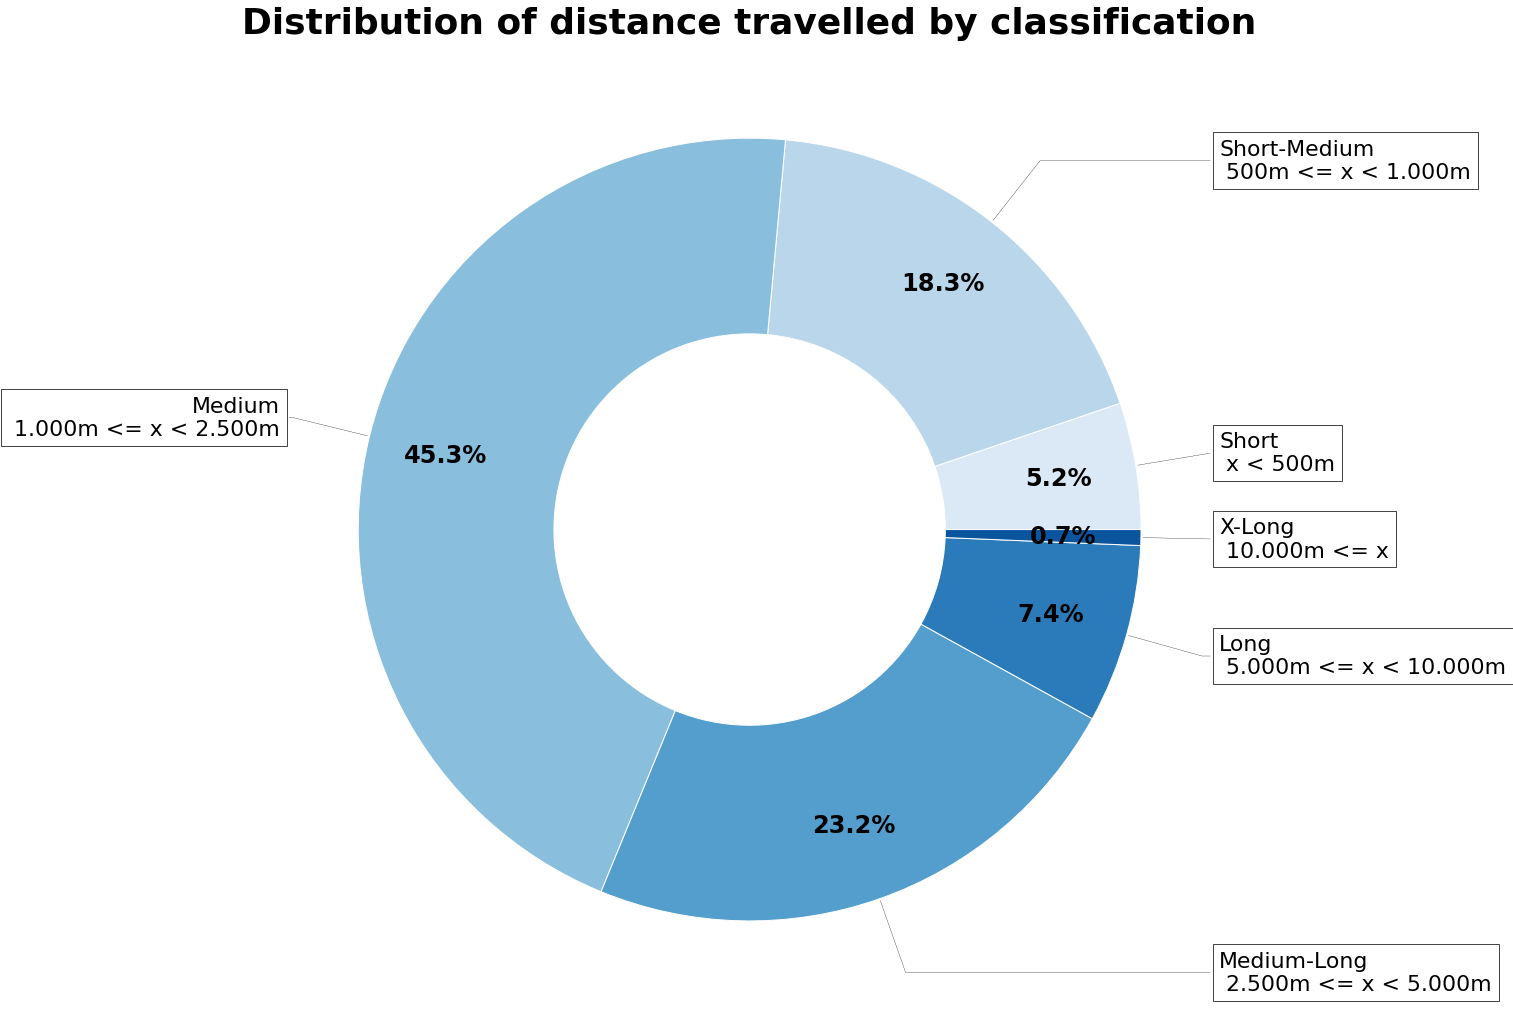

In [36]:
df_dist_class_distri = df_cleaned_v3.groupby('dist_class')['ride_id'].count().reset_index()
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))

wedges, texts, autotexts = ax.pie(df_dist_class_distri['ride_id'], autopct='%1.1f%%', pctdistance=0.8, wedgeprops = {'width': 0.5, 'linewidth' : 1, 'edgecolor' : 'white' },
                        colors = sns.color_palette("Blues")[:len(df_dist_class_distri)], startangle= 0,
                        textprops={'fontsize':24, 'fontweight':'bold'}
)

ax.set_title('Distribution of distance travelled by classification', 
                     fontsize = 36, weight = 'bold')

annotations = ["Short\n x < 500m",
          "Short-Medium\n 500m <= x < 1.000m",
          "Medium\n 1.000m <= x < 2.500m",
          "Medium-Long\n 2.500m <= x < 5.000m",
          "Long\n 5.000m <= x < 10.000m",
          "X-Long\n 10.000m <= x"]

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(annotations[i], xy=(x, y), xytext=(1.2*np.sign(x), 1.2*y),
                horizontalalignment=horizontalalignment, **kw)

# del df_dist_class_distri

plt.savefig('./../pictures/donut_distclass.png', transparent = True)

plt.show()


But is there a difference between the two groups and their ride distance?

#### Histogram

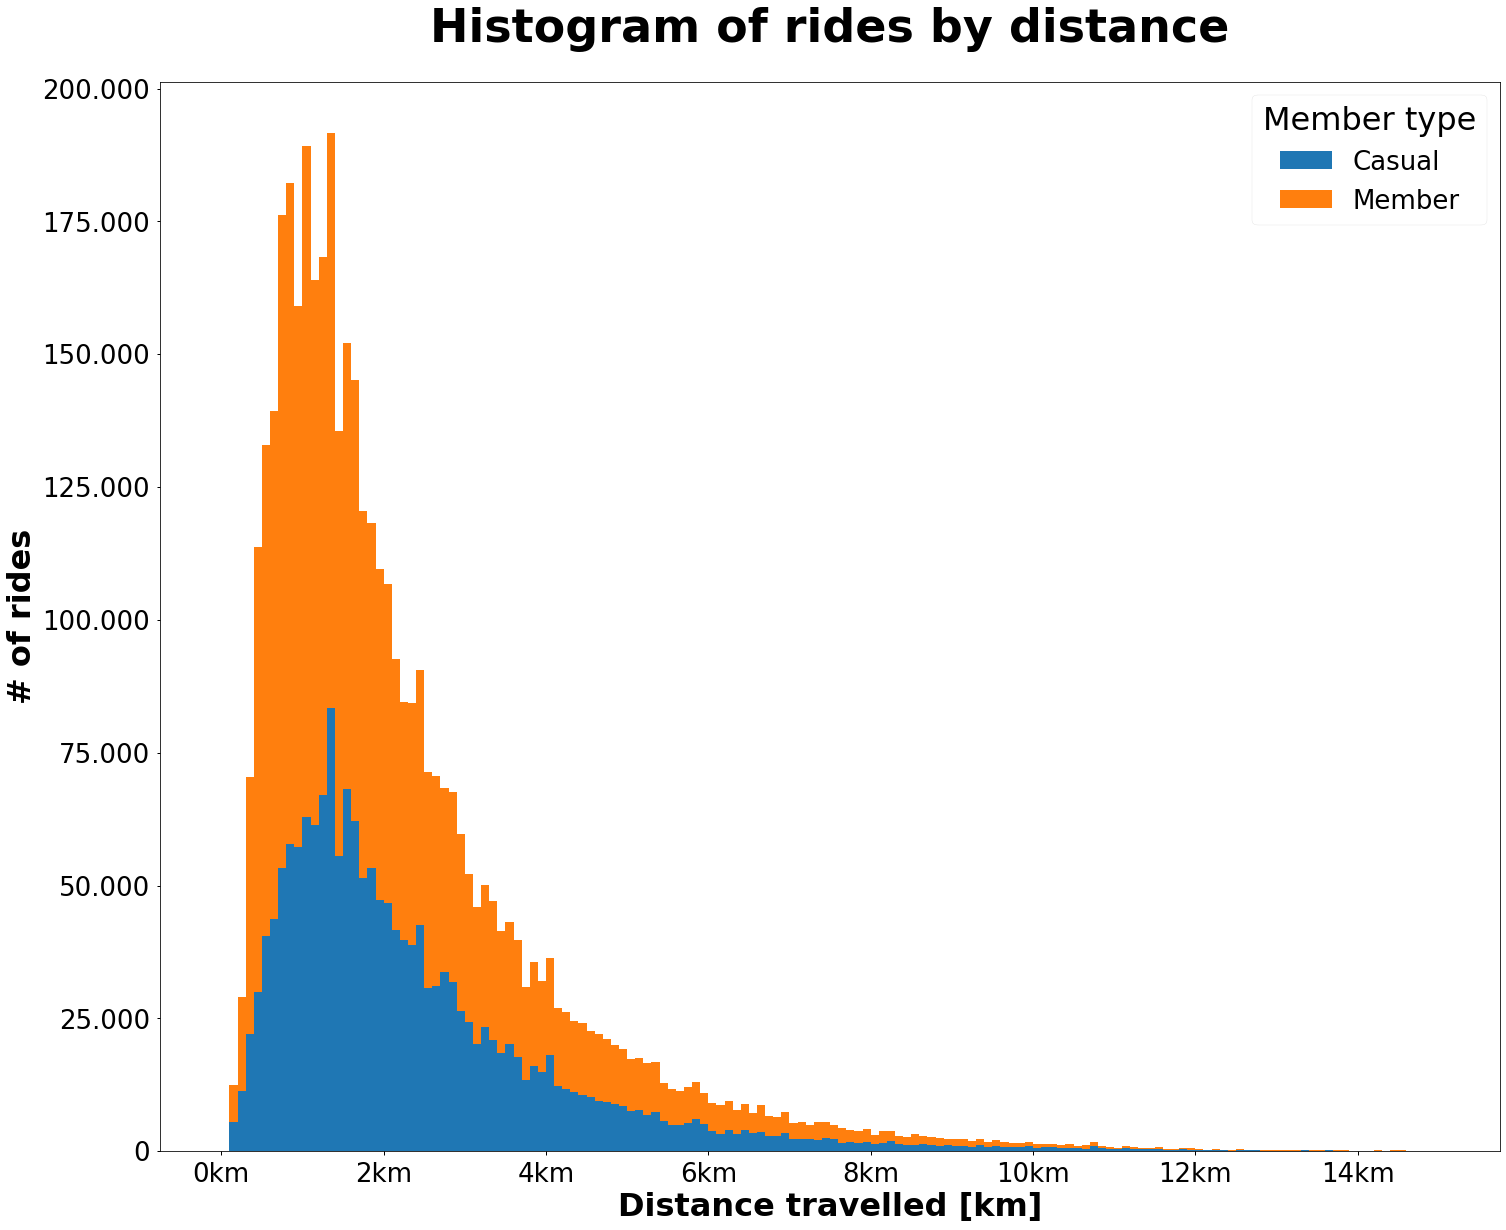

In [37]:
fig, ax = plt.subplots()

member = df_cleaned_v3.loc[df_cleaned_v3['member_casual']=='Member']['dist_ride']
casual = df_cleaned_v3.loc[df_cleaned_v3['member_casual']=='Casual']['dist_ride']
ax.hist([casual,member], bins =150, histtype='bar', stacked=True, label=['Casual', 'Member'], range=[0, 15000])
ax.set_title('Histogram of rides by distance', pad = 40)
ax.legend(title='Member type', loc='upper right')
ax.set_ylabel('# of rides', fontsize = 32, weight = 'bold')
ax.set_xlabel('Distance travelled [km]', fontsize = 32, weight = 'bold')
ax.xaxis.set_major_formatter(mat_tick.FuncFormatter(lambda x, p:
    f'{locale.format_string("%d", round(x/1000,2), grouping=True)}km'))
ax.yaxis.set_major_formatter(mat_tick.FuncFormatter(lambda x, p:
    f'{locale.format_string("%d", x, grouping=True)}'))

fig.subplots_adjust(top=.95)

plt.savefig('./../pictures/hist_ridedistance.png', transparent = True)
plt.show()

The histogramm suggests that the casual riders ride slightly longer distances. Also it can be seen very well that the members use Cyclist more often.

But is there a difference in ride behaviour (number of rides, as well as distance) in the weekdays?

#### Violinplot for member-type and weekday

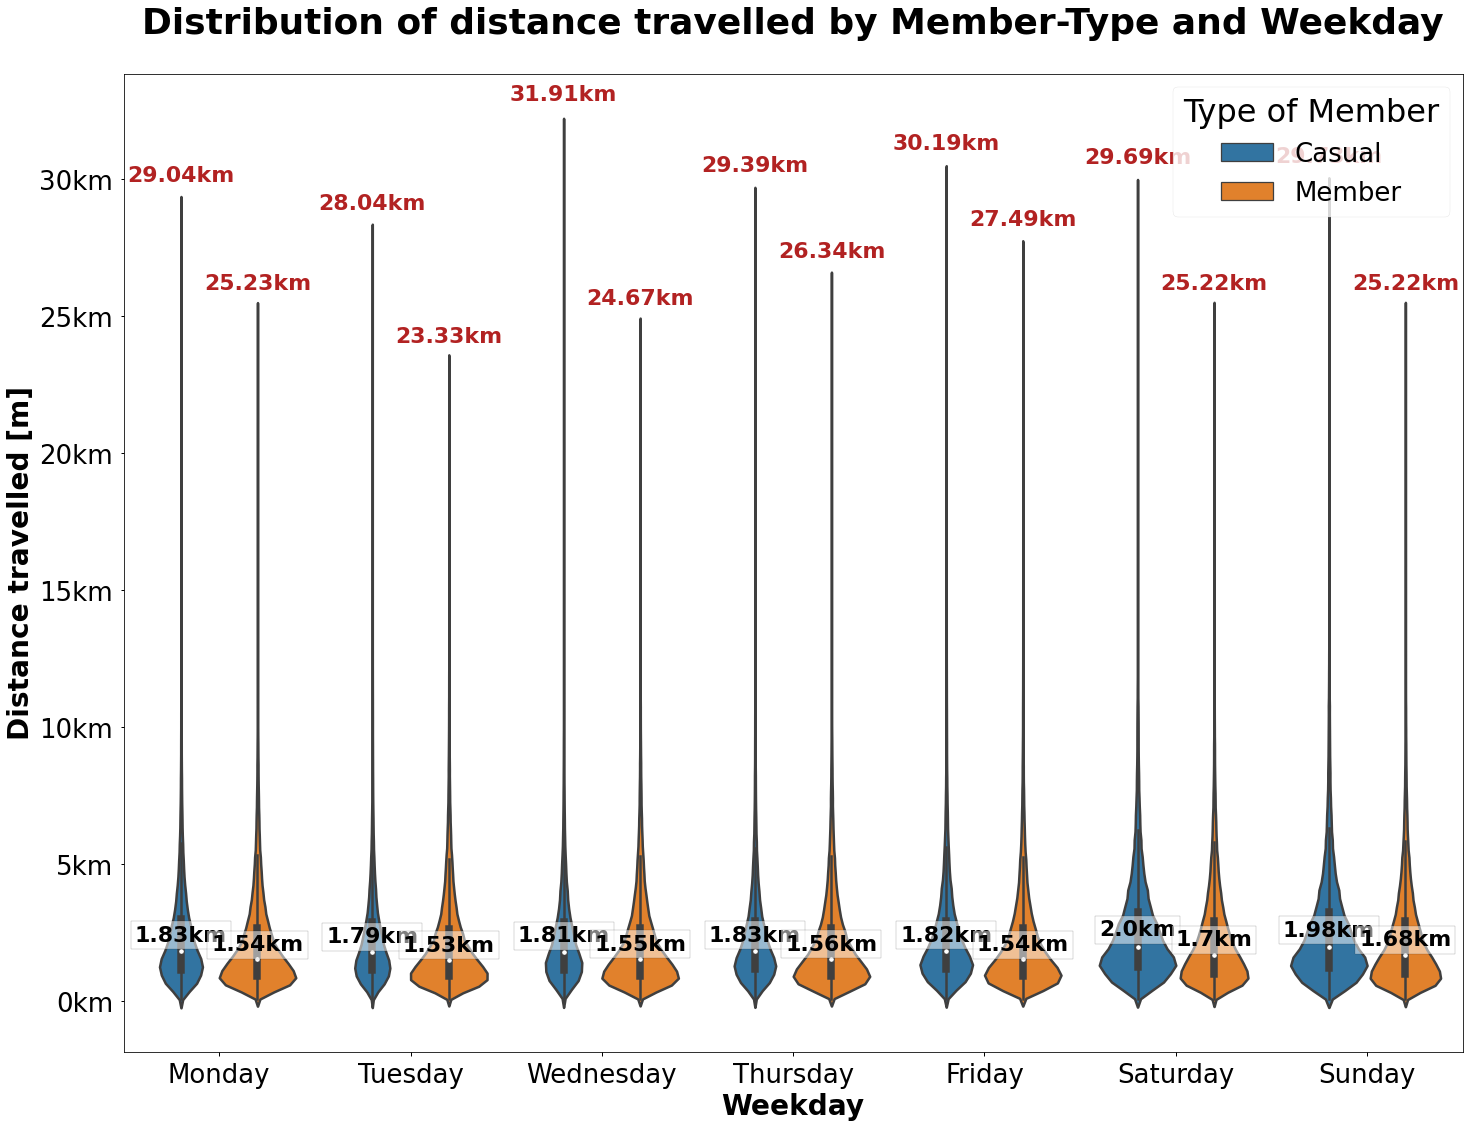

In [38]:
fig, ax = plt.subplots()

# boxplot = df_cleaned_v3.boxplot(column=['dist_ride','ride_timedelta'], by='member_casual')
ax = sns.violinplot(x="day_of_ride", y="dist_ride", hue="member_casual",  hue_order = ['Casual','Member'],
            data=df_cleaned_v3, linewidth=2.5, whis=[1,99], scale='count',
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday' ],
        #     height = 1200, widht= 1600
        )
ax.yaxis.set_major_formatter(mat_tick.FuncFormatter(lambda x, p: f'{locale.format_string("%d", round(x/1000,2), grouping=True)}km'))
ax.legend(fontsize=26, title='Type of Member')
ax.set_title('Distribution of distance travelled by Member-Type and Weekday', 
                     fontsize = 36, weight = 'bold', pad = 40)
ax.set_ylabel('Distance travelled [m]', fontsize = 28, weight = 'bold')
ax.set_xlabel('Weekday', fontsize = 28, weight = 'bold')

medians_dist = df_cleaned_v3.groupby(['day_of_ride','member_casual'])['dist_ride'].median()
max_dist = df_cleaned_v3.groupby(['day_of_ride','member_casual'])['dist_ride'].max()
vertical_offset = 1.2 # offset from median for display

i = 0
for xtick1 in ax.get_xticks():
    for n in range(2):
        i+= n%2
        iterator = xtick1 + i
        x_offset = xtick1 - 0.2 + 0.4*n
        t = ax.text(x_offset,medians_dist[iterator] * vertical_offset,f'{round(medians_dist[iterator]/1000,2)}km', 
                horizontalalignment='center',size='medium',color='black',weight='semibold')
        t.set_bbox(dict(facecolor='white', alpha=0.5))
        ax.text(x_offset,max_dist[iterator]*1.03, f'{round(max_dist[iterator]/1000,2)}km', 
                horizontalalignment='center',size='medium',color='firebrick',weight='semibold')

plt.savefig('./../pictures/violin_ridedist_weekday.png', transparent = True)
plt.show()

The violinplot of the ridedistance grouped by weekday and member type clearly shows that the number of rides for the casual members is significantly less in the workweek days (Mo-Fr) as shown by the slimmer widths of the violins. On weekends the casual riders even outweigh the members.

For both parties it also shows that the weekend comes with increased ride distances.

Next to the weekday is there also a difference when it comes to the months or the season?

#### Violinplot for member-type and month

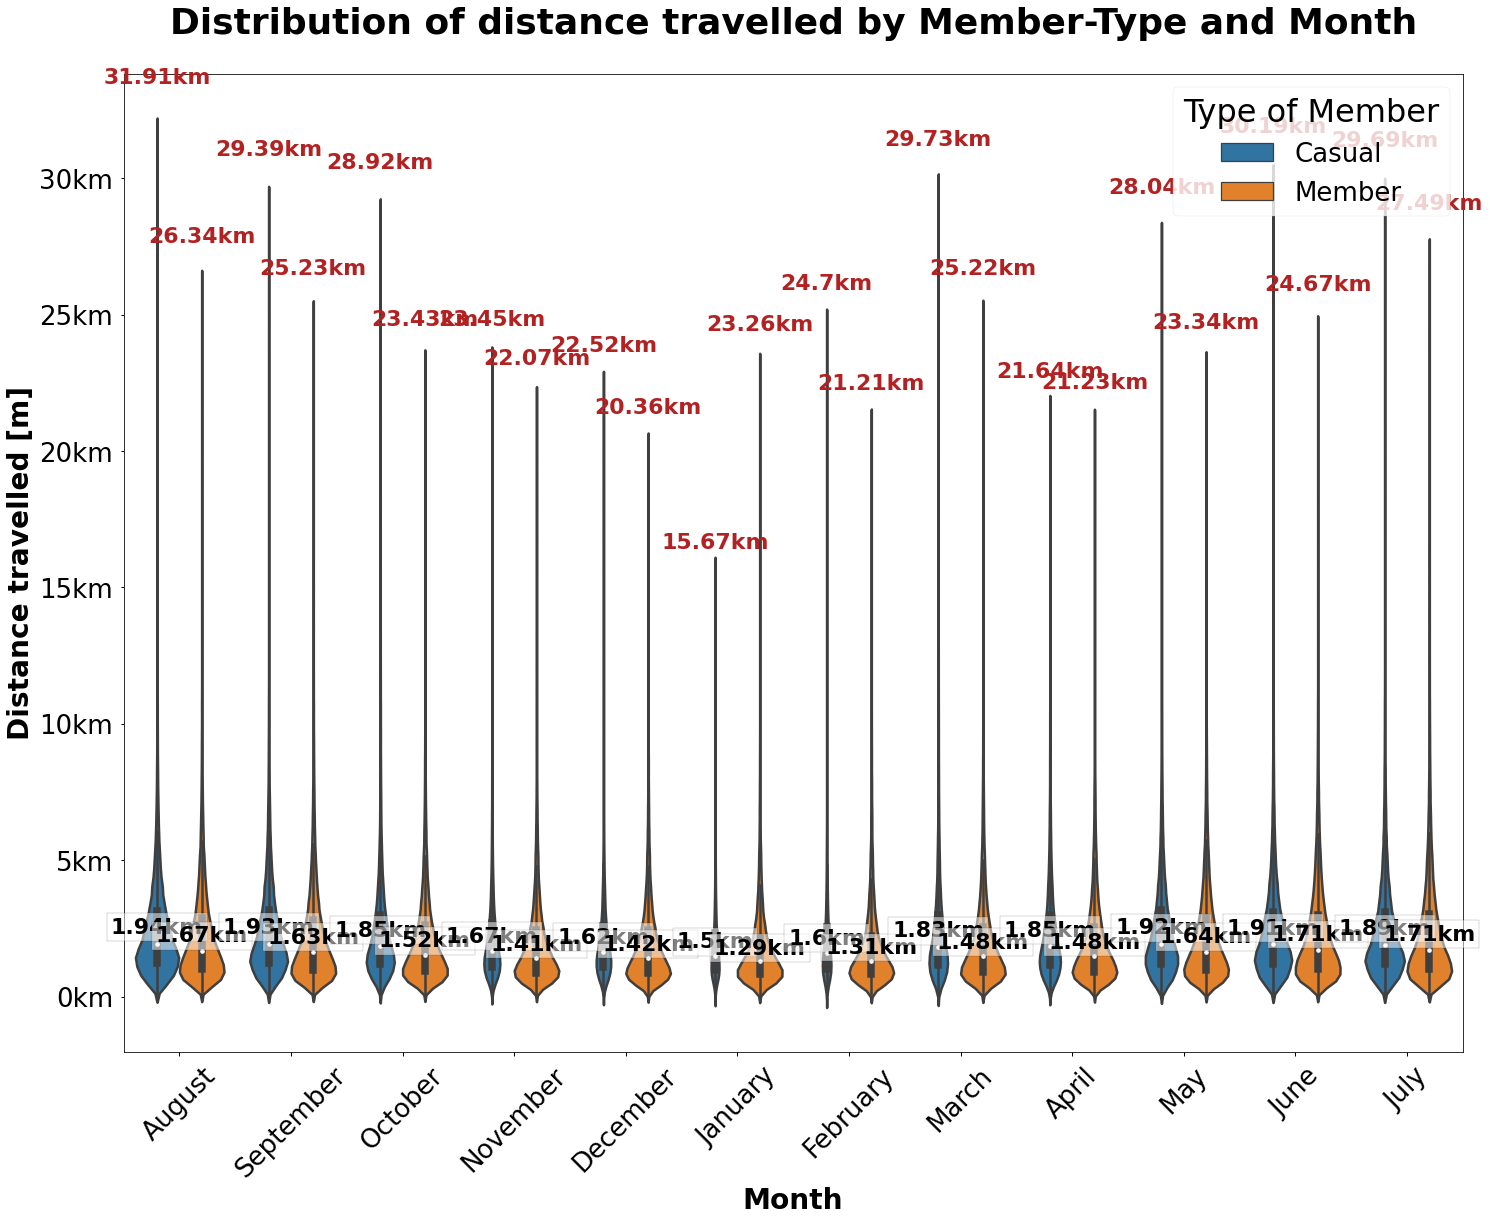

In [39]:
fig, ax = plt.subplots()

# boxplot = df_cleaned_v3.boxplot(column=['dist_ride','ride_timedelta'], by='member_casual')
ax = sns.violinplot(x="month_of_ride", y="dist_ride", hue="member_casual",  hue_order = ['Casual','Member'],
            data=df_cleaned_v3, linewidth=2.5, whis=[1,99], scale='count'
                 )
ax.yaxis.set_major_formatter(mat_tick.FuncFormatter(lambda x, p: f'{locale.format_string("%d", round(x/1000,2), grouping=True)}km'))
ax.legend(fontsize=26, title='Type of Member')
ax.set_title('Distribution of distance travelled by Member-Type and Month', pad = 40,
                     fontsize = 36, weight = 'bold')
ax.set_ylabel('Distance travelled [m]', fontsize = 28, weight = 'bold')
ax.set_xlabel('Month', fontsize = 28, weight = 'bold')
plt.xticks(rotation = 45)

medians_dist = df_cleaned_v3.groupby(['month_of_ride','member_casual'])['dist_ride'].median()
max_dist = df_cleaned_v3.groupby(['month_of_ride','member_casual'])['dist_ride'].max()
# print(medians)
vertical_offset = 1.2 # offset from median for display

i = 0
for xtick1 in ax.get_xticks():
    for n in range(2):
        i+= n%2
        iterator = xtick1 + i
        x_offset = xtick1 - 0.2 + 0.4*n
        t = ax.text(x_offset,medians_dist[iterator] * vertical_offset,f'{round(medians_dist[iterator]/1000,2)}km', 
                horizontalalignment='center',size='medium',color='black',weight='semibold')
        t.set_bbox(dict(facecolor='white', alpha=0.5))
        ax.text(x_offset,max_dist[iterator]*1.05, f'{round(max_dist[iterator]/1000,2)}km', 
                horizontalalignment='center',size='medium',color='firebrick',weight='semibold')

plt.savefig('./../pictures/violin_ridedist_month.png', transparent = True)
plt.show()

The above violinplot is similar to the one before with the only diffeerence that the weekdays are substituted by the months. Here we also see a drastic reduction in rides (width of violin) for the cold months starting from October and stretching to March. January and February are especially low volume for the casual riders whereas the members still ride almost as much as during the summers.

Also for both parties the distance travelled is shorter during the winter months.

### Ride length [t]

Next let's look at the difference in riding behaviour for the length of the ride.

In [40]:
#### Boxplot - Ride-length by Member-Type and Weekday

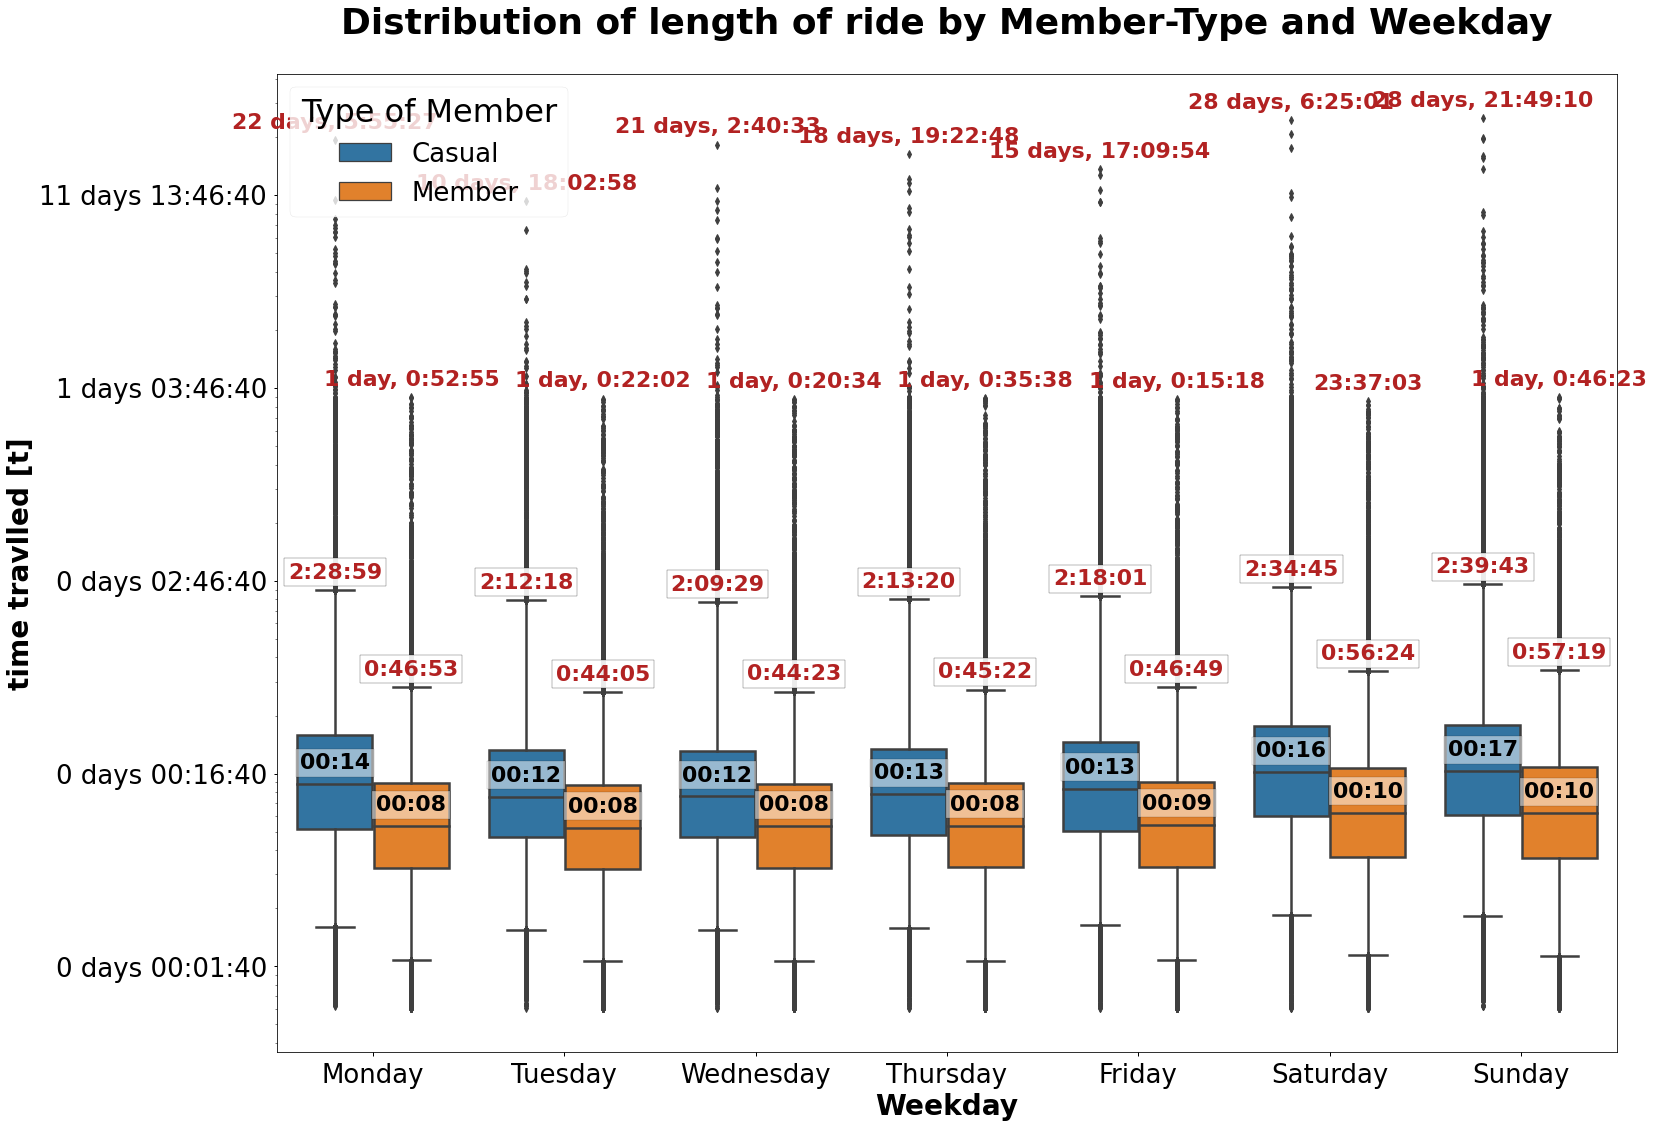

In [41]:
ax = sns.boxplot(x="day_of_ride", y="length_of_ride_s", hue="member_casual",  hue_order = ['Casual','Member'],
            data=df_cleaned_v3, linewidth=2.5, whis=[1,99]
        )
ax.legend(fontsize=26, title='Type of Member')
ax.set_title('Distribution of length of ride by Member-Type and Weekday', 
                     fontsize = 36, weight = 'bold', pad = 40)
ax.set_ylabel('time travlled [t]', fontsize = 28, weight = 'bold')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(mat_tick.FuncFormatter(lambda x, p: pd.to_timedelta(x, unit='s')))
ax.set_xlabel('Weekday', fontsize = 28, weight = 'bold')

medians_time = df_cleaned_v3.groupby(['day_of_ride','member_casual'])['length_of_ride_s'].median()
max_time = df_cleaned_v3.groupby(['day_of_ride','member_casual'])['length_of_ride_s'].max()
top_99 = df_cleaned_v3.groupby(['day_of_ride','member_casual'])['length_of_ride_s'].quantile(q=0.99, interpolation='nearest')

vertical_offset = 1.2 # offset from median for display

i = 0
for xtick1 in ax.get_xticks():
    for n in range(2):
        i+= n%2
        iterator = xtick1 + i
        x_offset = xtick1 - 0.2 + 0.4*n
        t = ax.text(x_offset,medians_time[iterator] * vertical_offset, strfdelta(datetime.timedelta(seconds=medians_time[iterator]),'%H:%M'), 
                horizontalalignment='center',size='medium',color='black',weight='semibold')
        t.set_bbox(dict(facecolor='white', alpha=0.5))
        ax.text(x_offset,max_time[iterator]*1.15, datetime.timedelta(seconds=max_time[iterator]), 
                horizontalalignment='center',size='medium',color='firebrick',weight='semibold')
        t2 = ax.text(x_offset,top_99[iterator]*1.15, datetime.timedelta(seconds=top_99[iterator]), 
                horizontalalignment='center',size='medium',color='firebrick',weight='semibold')
        t2.set_bbox(dict(facecolor='white', alpha=0.9))
        
medians_time = medians_time.reset_index()
max_time = max_time.reset_index()
top_99 = top_99.reset_index()

plt.savefig('./../pictures/boxplot_ridelength_day.png' , transparent = True)
plt.show()

In [42]:
md(f"""
The above boxplot shows that the casual riders spent a significant time longer on the bike - 
by {(medians_time.loc[medians_time['member_casual']=='Casual']['length_of_ride_s'].mean()/medians_time.loc[medians_time['member_casual']=='Member']['length_of_ride_s'].mean() - 1):.1%} to be exact 
(Casual: {strfdelta(datetime.timedelta(seconds = medians_time.loc[medians_time['member_casual']=='Casual']['length_of_ride_s'].mean()), "%H:%M:%S")} 
vs
Member: {strfdelta(datetime.timedelta(seconds = medians_time.loc[medians_time['member_casual']=='Member']['length_of_ride_s'].mean()), "%H:%M:%S")}).

In the case of the ride length for Top 1% of rides (99th Percentile) this is even more drastic:
Casual: {strfdelta(datetime.timedelta(seconds = top_99.loc[top_99['member_casual']=='Casual']['length_of_ride_s'].mean()), "%H:%M:%S")}
vs
Member: {strfdelta(datetime.timedelta(seconds = top_99.loc[top_99['member_casual']=='Member']['length_of_ride_s'].mean()), "%H:%M:%S")}.

So far this shows a clear difference in  riding behaviour during the weekend, but is there also more differences throughout the year?
""")


The above boxplot shows that the casual riders spent a significant time longer on the bike - 
by 54.4% to be exact 
(Casual: 00:14:25 
vs
Member: 00:09:20).

In the case of the ride length for Top 1% of rides (99th Percentile) this is even more drastic:
Casual: 02:22:22
vs
Member: 00:48:45.

So far this shows a clear difference in  riding behaviour during the weekend, but is there also more differences throughout the year?


#### Boxplot - Ride-length by Member-Type and Month

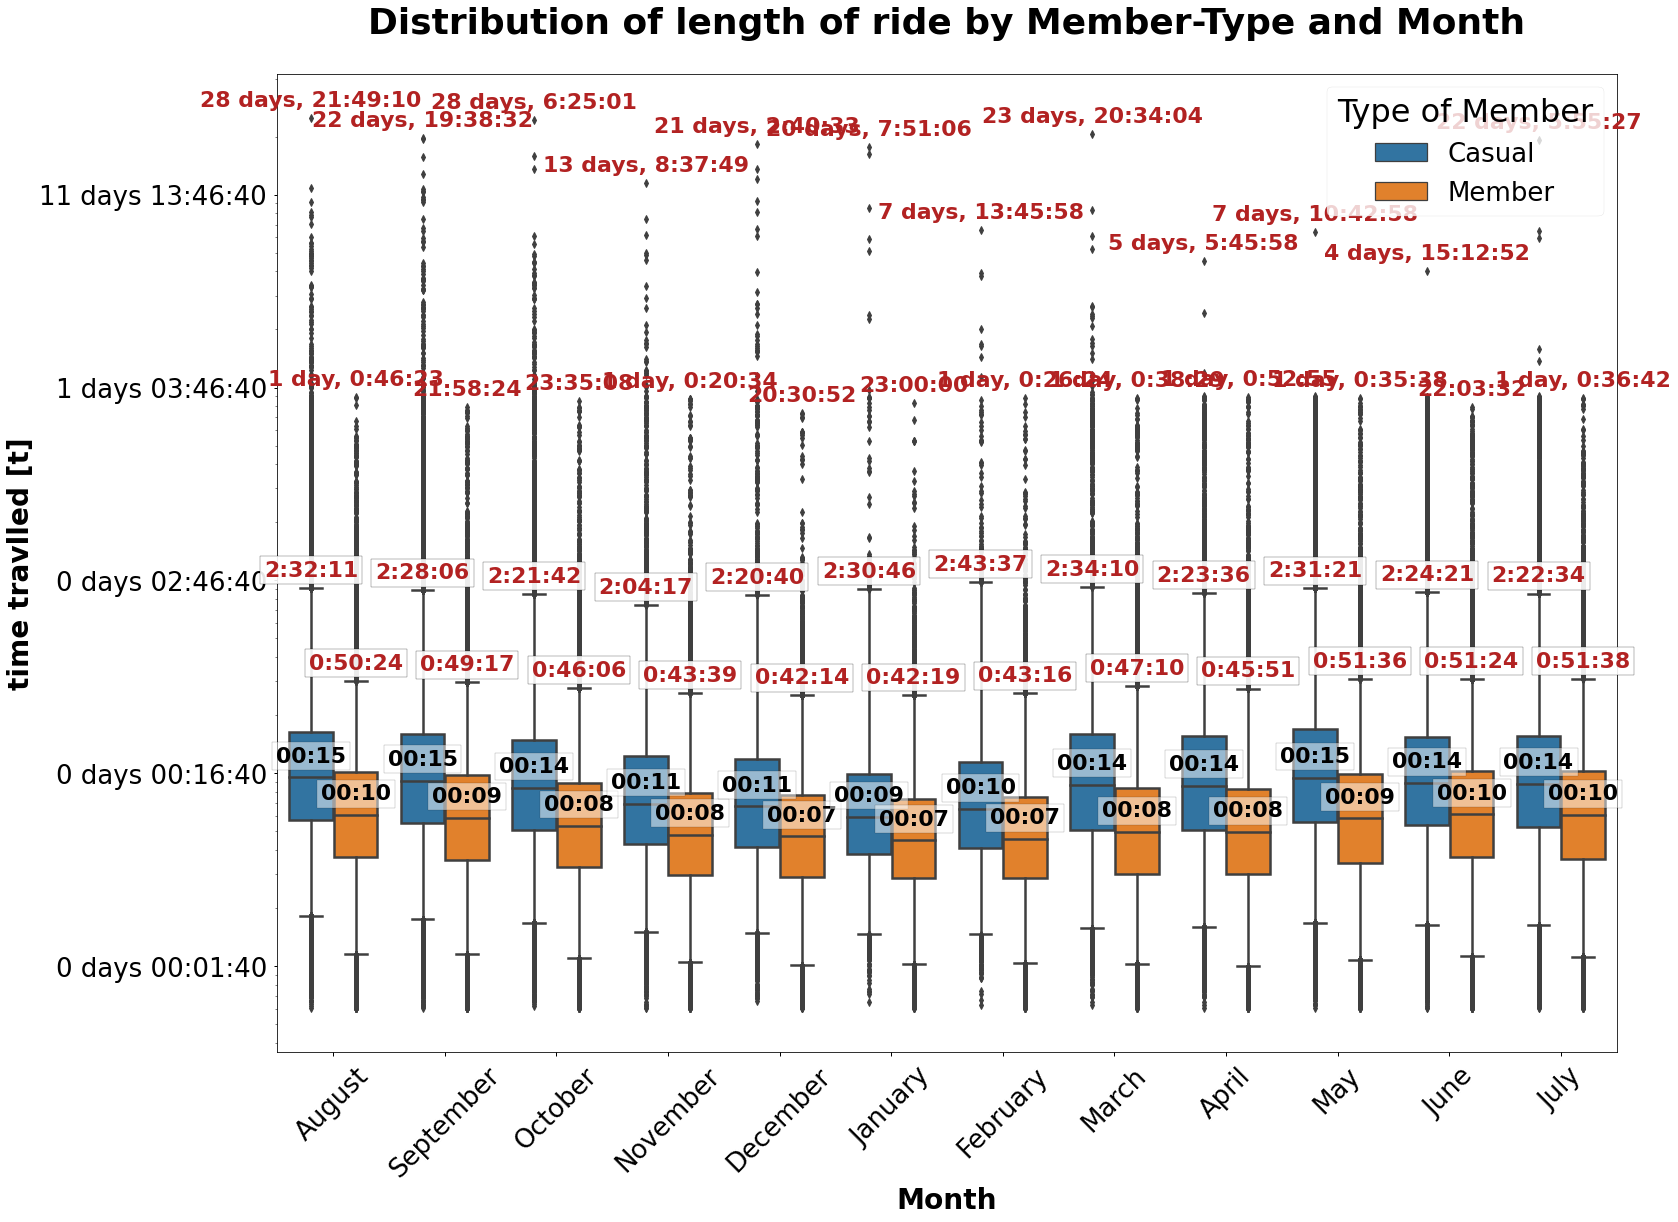

In [43]:
ax = sns.boxplot(x="month_of_ride", y="length_of_ride_s", hue="member_casual",  hue_order = ['Casual','Member'],
            data=df_cleaned_v3, linewidth=2.5, whis=[1,99]
                 )
ax.legend(fontsize=26, title='Type of Member')
ax.set_title('Distribution of length of ride by Member-Type and Month', pad = 40,
                     fontsize = 36, weight = 'bold')
ax.set_ylabel('time travlled [t]', fontsize = 28, weight = 'bold')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(mat_tick.FuncFormatter(lambda x, p: pd.to_timedelta(x, unit='s')))
ax.set_xlabel('Month', fontsize = 28, weight = 'bold')
plt.xticks(rotation = 45)

medians_time = df_cleaned_v3.groupby(['month_of_ride','member_casual'])['length_of_ride_s'].median()
max_time = df_cleaned_v3.groupby(['month_of_ride','member_casual'])['length_of_ride_s'].max()
top_99 = df_cleaned_v3.groupby(['month_of_ride','member_casual'])['length_of_ride_s'].quantile(q=0.99, interpolation='nearest')

vertical_offset = 1.2 # offset from median for display

i = 0
for xtick1 in ax.get_xticks():
    for n in range(2):
        i+= n%2
        iterator = xtick1 + i
        x_offset = xtick1 - 0.2 + 0.4*n
        t = ax.text(x_offset,medians_time[iterator] * vertical_offset, strfdelta(datetime.timedelta(seconds=medians_time[iterator]),'%H:%M'), 
                horizontalalignment='center',size='medium',color='black',weight='semibold')
        t.set_bbox(dict(facecolor='white', alpha=0.5))
        ax.text(x_offset,max_time[iterator]*1.15, datetime.timedelta(seconds=max_time[iterator]), 
                horizontalalignment='center',size='medium',color='firebrick',weight='semibold')
        t2 = ax.text(x_offset,top_99[iterator]*1.15, datetime.timedelta(seconds=top_99[iterator]), 
                horizontalalignment='center',size='medium',color='firebrick',weight='semibold')
        t2.set_bbox(dict(facecolor='white', alpha=0.9))

medians_time = medians_time.reset_index()
max_time = max_time.reset_index()
top_99 = top_99.reset_index()

plt.savefig('./../pictures/boxplot_ridelength_month.png', transparent = True)
plt.show()

In [44]:
md("""
The general difference in the ride length persisted throughout the year comparing the two groups.
There is howevere a synchronous change in ride length throughout the year for both. During the winter months (Oct - Mar)
the length of the ride drops by a significant ammount (ca. 30%) for both. The drop is slightly larger for the casual riders.

This seems to be innline with the previous findings that also the distance travelled is reduced in those months - however not by 30%.
During the winter months the riders seem to hurry more to get to their destination. Whereas in the summer
the motto seems to be "the ride is the goal" in Winter it shifts to "the destination is the goal".
""")


The general difference in the ride length persisted throughout the year comparing the two groups.
There is howevere a synchronous change in ride length throughout the year for both. During the winter months (Oct - Mar)
the length of the ride drops by a significant ammount (ca. 30%) for both. The drop is slightly larger for the casual riders.

This seems to be innline with the previous findings that also the distance travelled is reduced in those months - however not by 30%.
During the winter months the riders seem to hurry more to get to their destination. Whereas in the summer
the motto seems to be "the ride is the goal" in Winter it shifts to "the destination is the goal".


### Relation of distance and ride length

Now let's take a look at the relationship between the distance of the ride and the length.
By now we know that the distance travelled is slightly longer for casual riders, but the time needed for this more than the distance would suggest.

If there is a correlation between the ride distance and length of the ride, I expect it to be stronger for the members who travel almost as much as the casual riders in distance, but do it in a faster manner.

Also the docked bike has some gigantic outliers with the ride length (> 20 days). To get a good grasp lets take a look at the relationship of distance and ride length grouped by member-type and ride-type.

#### Linear Model of rides

In [45]:
import scipy as sp
# annotate lmplots with pearson r and p-value to understand the correlation and statistical significance
# used from https://stackoverflow.com/questions/25579227/seaborn-lmplot-with-equation-and-r2-text 
def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['length_of_ride_s'], data['dist_ride'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p), size = 14,
            transform=ax.transAxes)

C:\Users\kemke\AppData\Local\Temp\ipykernel_16356\1318206295.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



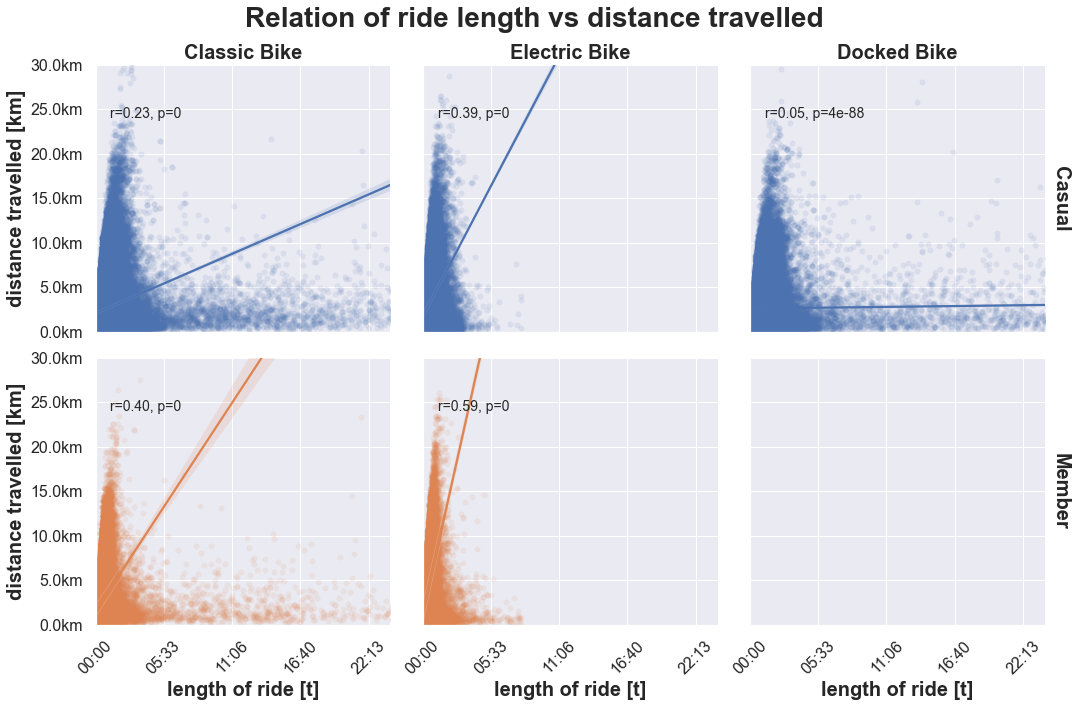

In [46]:
df_implot_temp = df_cleaned_v3[['member_casual','rideable_type', 'length_of_ride_s', 'dist_ride']]
df_implot_temp['rideable_type'] = df_implot_temp['rideable_type'].apply(lambda x: x.replace('_',' '))

sns.set(rc={'figure.figsize':(64,32),
        'xtick.labelsize':16,
        'ytick.labelsize':16})

g = sns.lmplot(data = df_implot_temp, x = 'length_of_ride_s', y = 'dist_ride', row = 'member_casual',
        ci = 99, col ='rideable_type', scatter_kws = {'alpha' : 0.1},  hue = 'member_casual', hue_order = ['Casual', 'Member'],
        facet_kws = {'sharex':True, 'sharey':True, 'legend_out':True, 'margin_titles':True},
        col_order = ['Classic Bike', 'Electric Bike', 'Docked Bike'], row_order= ['Casual', 'Member'],
        truncate=False
    )

g.set(xlim=(0, 24*60**2))
g.set(ylim=(0, 30*10**3))

plt.subplots_adjust(hspace=0.35)

g.set_axis_labels("length of ride [t]", "distance travelled [km]", fontsize = 20, weight = 'bold')

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(mat_tick.FuncFormatter(lambda x, p: f'{round(x/1000,1)}km'))
    ax.xaxis.set_major_formatter(mat_tick.FuncFormatter(lambda x, p: strfdelta(pd.to_timedelta(x, unit='s'), '%H:%M')))
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        
g.map_dataframe(annotate)
g.fig.suptitle('Relation of ride length vs distance travelled', 
                     fontsize = 28, weight = 'bold')
g.set_titles(col_template="{col_name}", row_template="{row_name}", size = 20, weight = 'bold')
g.figure.subplots_adjust(top=.9)
        
plt.savefig('./../pictures/lmplot_length_vs_dist.png', transparent = True)
plt.show()

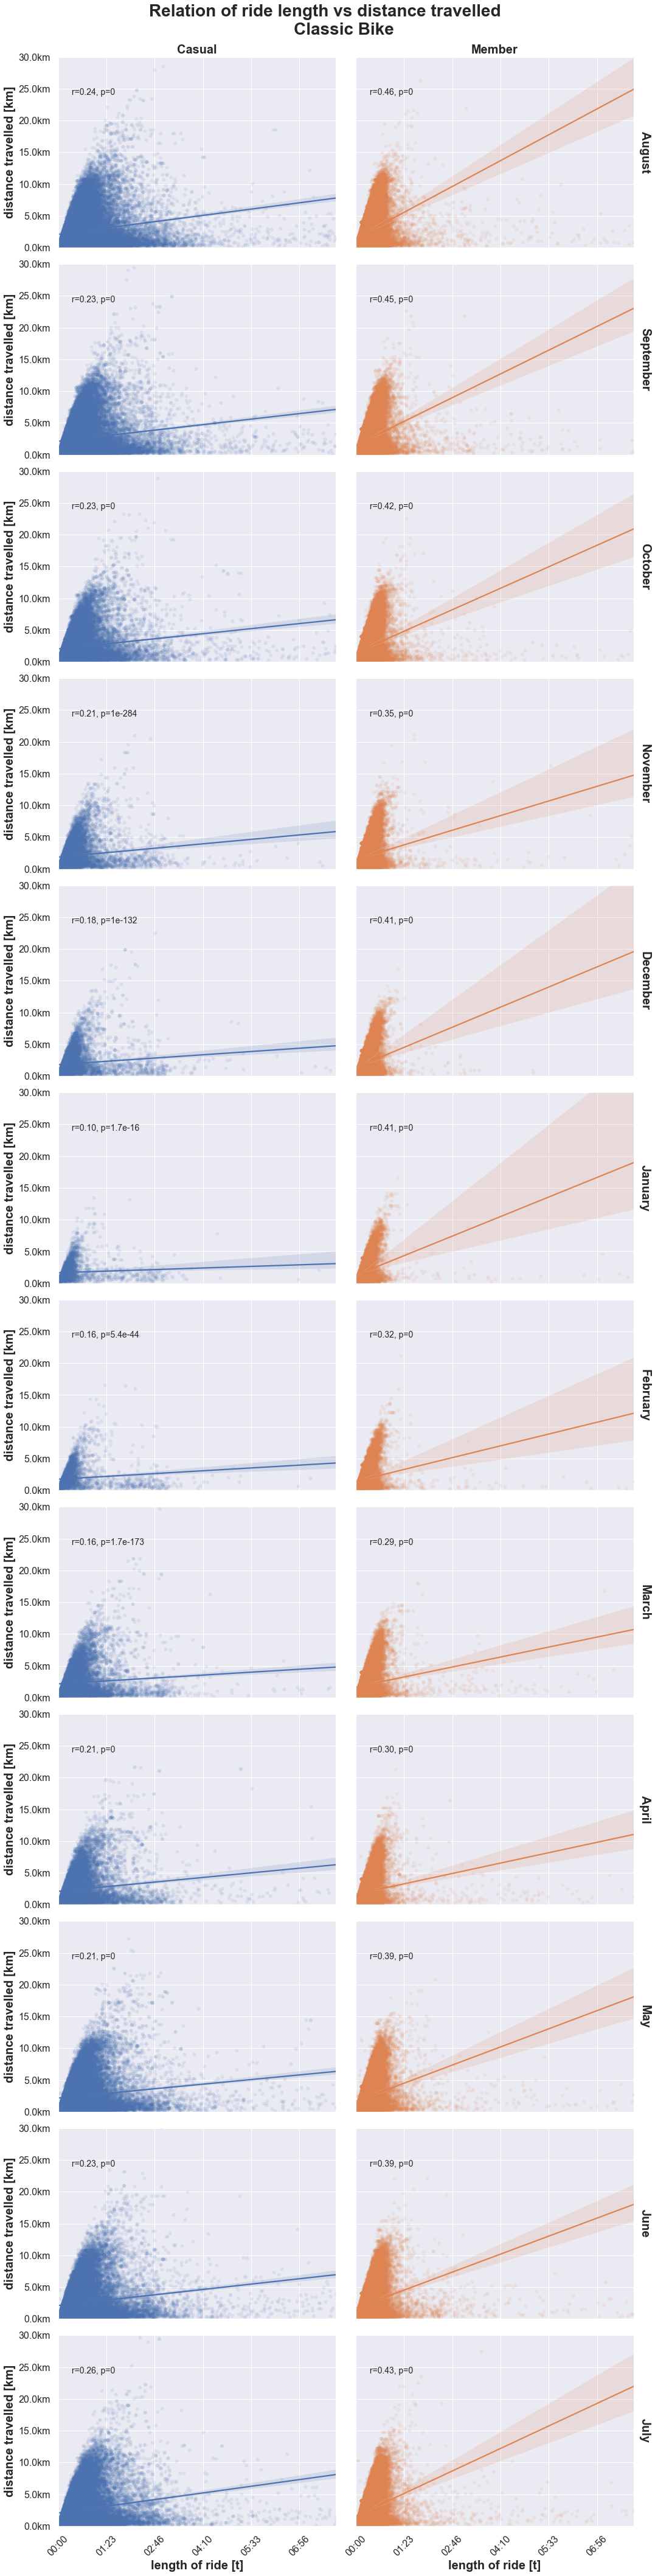

In [47]:
# DF of classic bike
df_implot_temp = df_cleaned_v3[['member_casual','rideable_type', 'month_of_ride','length_of_ride_s', 'dist_ride']]\
    .loc[(df_cleaned_v3['rideable_type']=="Classic Bike")]

sns.set(rc={'figure.figsize':(64,32),
        'xtick.labelsize':16,
        'ytick.labelsize':16})

g = sns.lmplot(data = df_implot_temp, x = 'length_of_ride_s', y = 'dist_ride', ci = 99, col ='member_casual', col_order = ['Casual', 'Member'],
        row = 'month_of_ride', scatter_kws = {'alpha' : 0.1},  hue = 'member_casual', hue_order = ['Casual', 'Member'], aspect = 1.5,
        facet_kws = {'sharex':True, 'sharey':True, 'legend_out':True, 'margin_titles':True},
        # col_order = ['Classic Bike', 'Electric Bike', 'Docked Bike'], row_order= ['Casual', 'Member'],
        truncate=False
    )
g.set(xlim=(0, 8*60**2)) # limit to 8 hours day
g.set(ylim=(0, 30*10**3)) # limit to 30km

plt.subplots_adjust(hspace=0.25)

g.set_axis_labels("length of ride [t]", "distance travelled [km]", fontsize = 20, weight = 'bold')

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(mat_tick.FuncFormatter(lambda x, p: f'{round(x/1000,1)}km'))
    ax.xaxis.set_major_formatter(mat_tick.FuncFormatter(lambda x, p: strfdelta(pd.to_timedelta(x, unit='s'), '%H:%M')))
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        
g.map_dataframe(annotate)
g.set_titles(col_template="{col_name}", row_template="{row_name}", size = 20, weight = 'bold')
g.fig.suptitle("""Relation of ride length vs distance travelled
        Classic Bike""", 
                     fontsize = 28, weight = 'bold')
g.figure.subplots_adjust(top=.96)

plt.savefig('./../pictures/lmplot_length_vs_dist_classic_bike.png', dpi = 300, transparent = True)
plt.show()

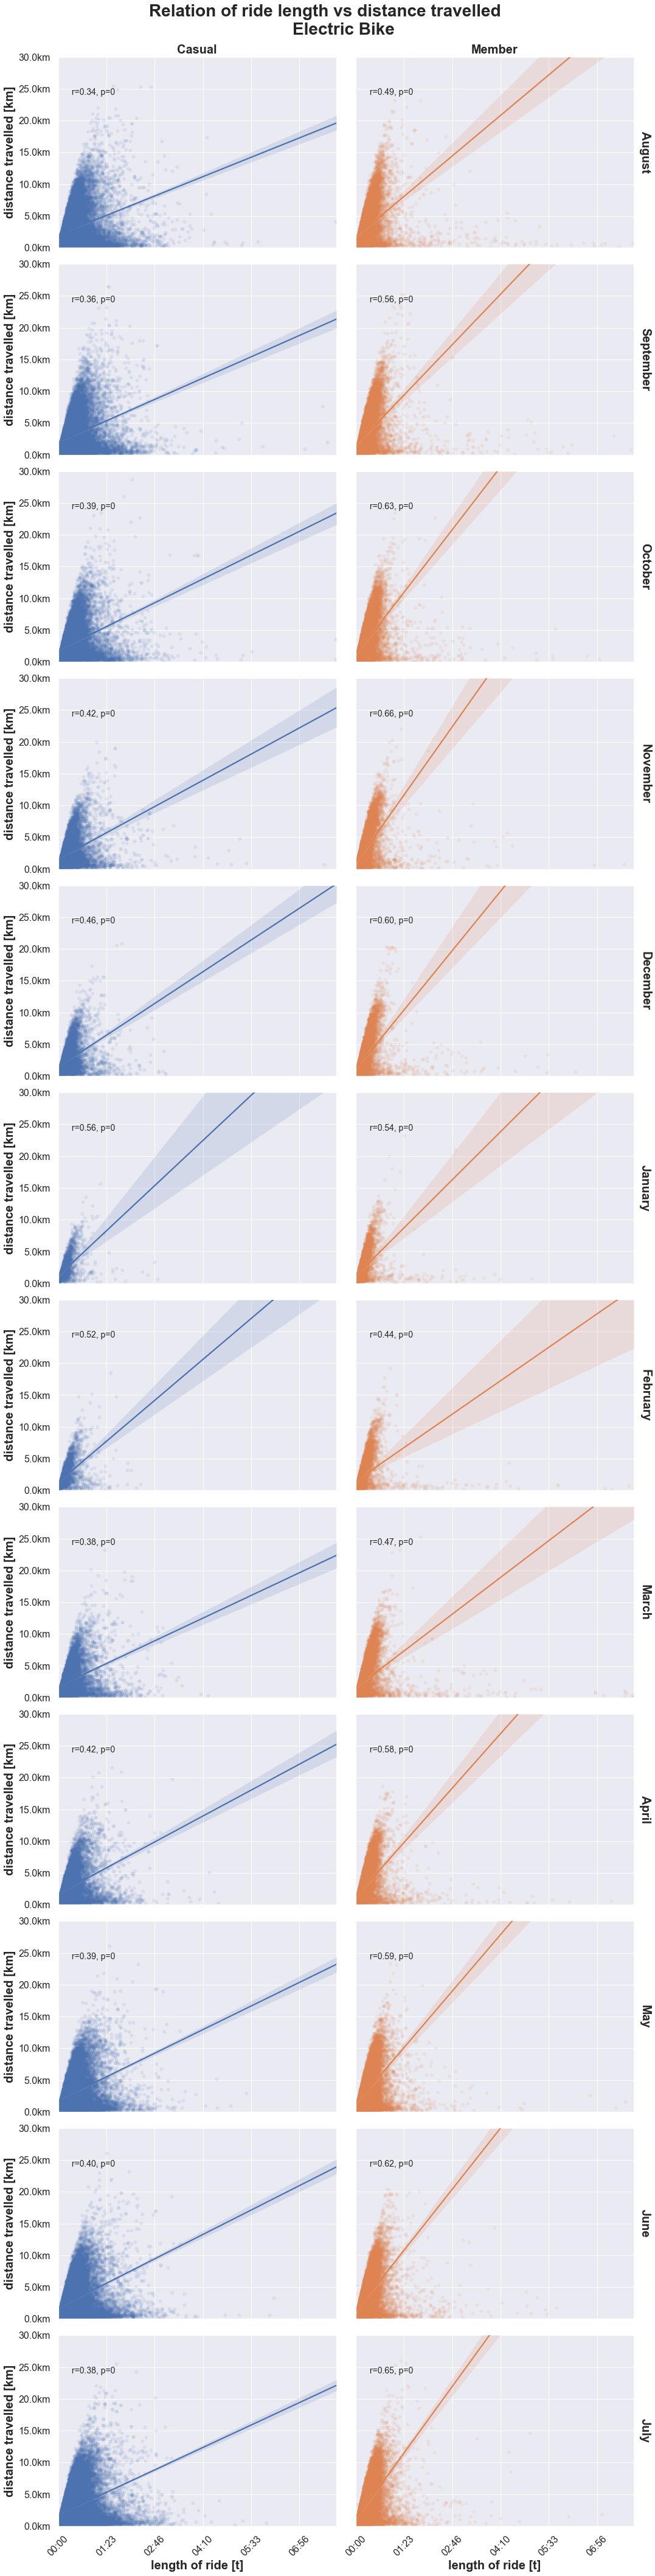

In [48]:
# DF of electric bike
df_implot_temp = df_cleaned_v3[['member_casual','rideable_type', 'month_of_ride','length_of_ride_s', 'dist_ride']]\
    .loc[(df_cleaned_v3['rideable_type']=="Electric Bike")]

sns.set(rc={'figure.figsize':(64,32),
        'xtick.labelsize':16,
        'ytick.labelsize':16})

g = sns.lmplot(data = df_implot_temp, x = 'length_of_ride_s', y = 'dist_ride', ci = 99, col ='member_casual', col_order = ['Casual', 'Member'],
        row = 'month_of_ride', scatter_kws = {'alpha' : 0.1},  hue = 'member_casual', hue_order = ['Casual', 'Member'], aspect = 1.5,
        facet_kws = {'sharex':True, 'sharey':True, 'legend_out':True, 'margin_titles':True},
        # col_order = ['Classic Bike', 'Electric Bike', 'Docked Bike'], row_order= ['Casual', 'Member'],
        truncate=False
    )
g.set(xlim=(0, 8*60**2)) # limit to 8 hours
g.set(ylim=(0, 30*10**3))

plt.subplots_adjust(hspace=0.25)

g.set_axis_labels("length of ride [t]", "distance travelled [km]", fontsize = 20, weight = 'bold')

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(mat_tick.FuncFormatter(lambda x, p: f'{round(x/1000,1)}km'))
    ax.xaxis.set_major_formatter(mat_tick.FuncFormatter(lambda x, p: strfdelta(pd.to_timedelta(x, unit='s'), '%H:%M')))
    for label in ax.get_xticklabels():
        label.set_rotation(45)

g.map_dataframe(annotate)
g.set_titles(col_template="{col_name}", row_template="{row_name}", size = 20, weight = 'bold')
g.fig.suptitle("""Relation of ride length vs distance travelled
        Electric Bike""", 
                     fontsize = 28, weight = 'bold')
g.figure.subplots_adjust(top=.96)

plt.savefig('./../pictures/lmplot_length_vs_dist_electric_bike.png', dpi = 300, transparent = True)
plt.show()

### Stations and routes used

Now let's take a look if there is a geographical difference as well. Let's look at the most used stations for this and then plot it into the map.

#### Barchart - Visited Stations

#### Map Scatterplot - Visited Stations

Now let's visualize the difference in used stations and plot it onto the map. The size of the marker will indicate how frequently the station is visited by each member-type.

c:\Users\kemke\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:337: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.

c:\Users\kemke\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:670: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



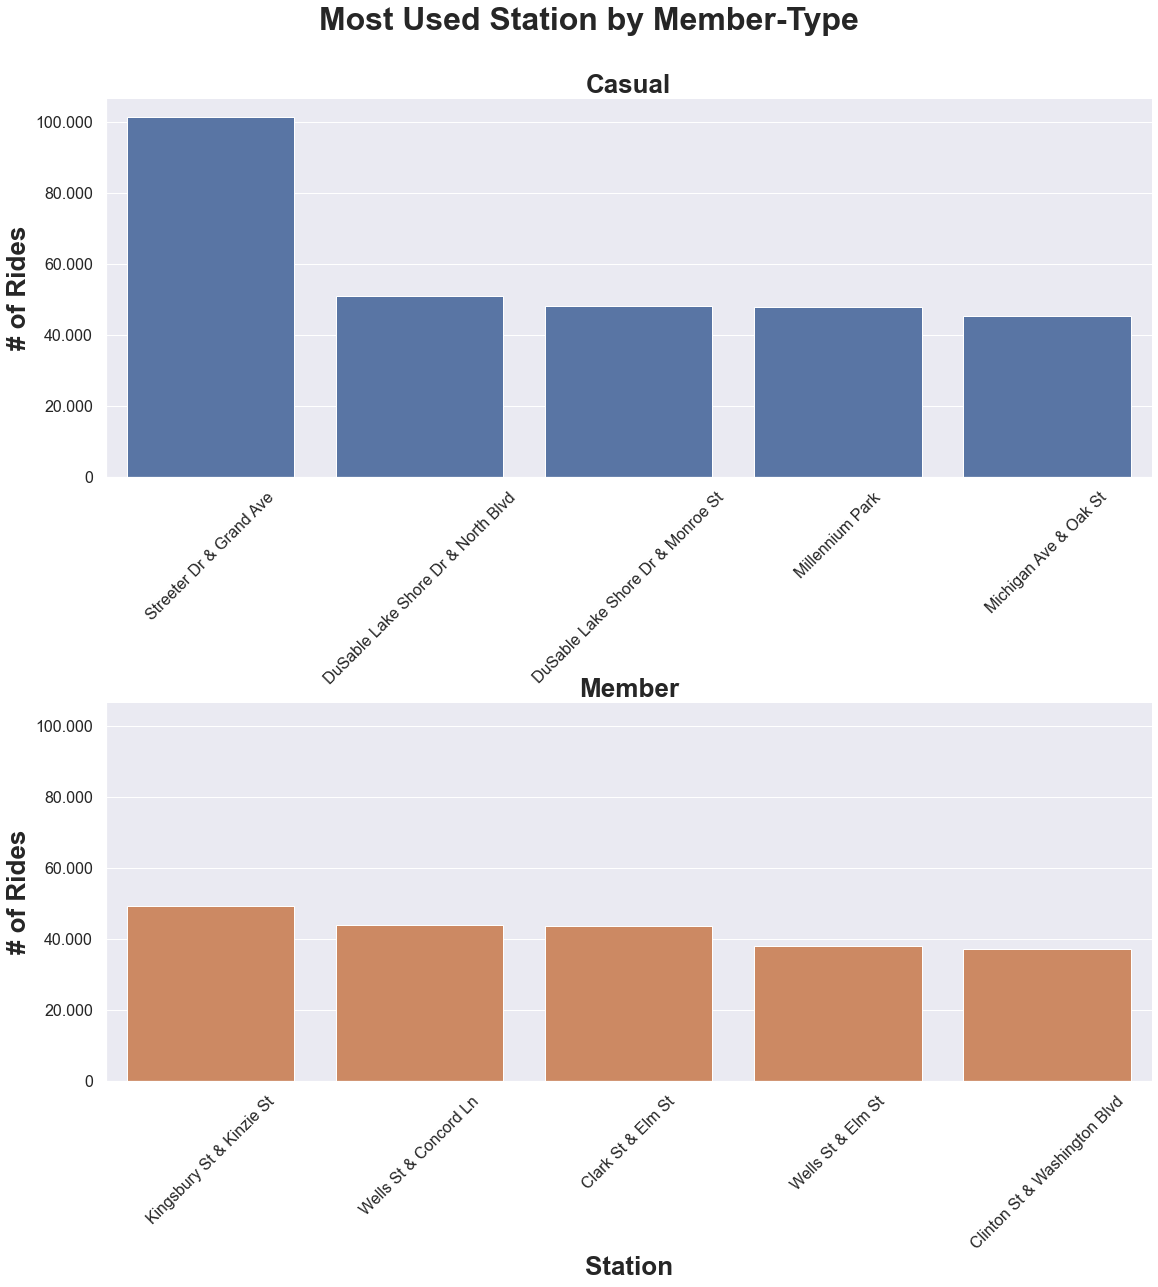

In [49]:
try:
    most_common_station.reset_index(inplace=True)
except:
    pass

g = sns.FacetGrid(most_common_station, row="member_casual",hue="member_casual", size=8, aspect=2, sharex=False)
g.map(sns.barplot,'station_name','no_of_rides')
g.fig.suptitle('Most Used Station by Member-Type', 
                     fontsize = 32, weight = 'bold')
g.fig.subplots_adjust(top=0.9) 
g.set_axis_labels("Station", "# of Rides", fontsize=26, weight='bold')
g.set_titles(row_template="{row_name}", size=26)

plt.subplots_adjust(hspace=0.6)

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(mat_tick.FuncFormatter(lambda x, p: locale.format_string('%d', x , grouping=True)))
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        
plt.savefig('./../pictures/most_station.png')
plt.show()

In [50]:
# Create DF for the map scatterplot
scatter_map_df = df_cleaned_v3[['member_casual','start_station_id','end_station_id']].melt(id_vars=['member_casual'], var_name='station_type', value_name='station_id')\
    .groupby(['member_casual','station_id']).apply(lambda df: pd.Series({
        'no_of_rides':  df['station_type'].count()
    })).reset_index()
    
mean_lat_lng = df_cleaned_v3.groupby(['start_station_id','start_station_name'])\
    .apply(lambda df: pd.Series({
        'lat': df['start_lat'].mean(),
        'lng': df['start_lng'].mean(),
    })).reset_index().rename(columns={'start_station_id':'station_id', 'start_station_name': 'station_name'})
    
scatter_map_df = scatter_map_df.merge(mean_lat_lng, how = 'left', on = 'station_id').dropna(how='any')


member_casual    station_id  no_of_rides  \
0           Casual        021320           39   
2           Casual          1012            5   
3           Casual          1013            1   
5           Casual          1019            7   
6           Casual         13001        20438   
...            ...           ...          ...   
2496        Member  chargingstx0           42   
2497        Member  chargingstx1         4856   
2498        Member  chargingstx3         5084   
2499        Member  chargingstx4         3109   
2500        Member  chargingstx5         3510   

                                  station_name        lat        lng  
0                               MTV Hubbard St  41.890000 -87.680000  
2          Public Rack - Langley Ave & 49th St  41.805000 -87.610000  
3           Public Rack - Pulaski Rd & Lake St  41.890000 -87.730000  
5     Public Rack - Kostner Ave & Diversey Ave  41.930000 -87.740000  
6                 Michigan Ave & Washington St  41.883966 -87.624564  
...                                        ...        ...        ...  
2496               Wilton Ave & Diversey Pkwy*  41.932419 -87.652707  
2497                Bissell St & Armitage Ave*  41.918344 -87.652190  
2498                   Green St & Randolph St*  41.883596 -87.648588  
2499                      Morgan St & Lake St*  41.885499 -87.652317  
2500                  Lincoln Ave & Roscoe St*  41.943345 -87.670723  

[2434 rows x 6 columns]

In [52]:
mapbox_acces_token = px.set_mapbox_access_token(open("../mapbox_token_public.json").read())
fig = px.scatter_mapbox(scatter_map_df,
                    lat=scatter_map_df['lat'],
                    lon=scatter_map_df['lng'],
                    size='no_of_rides',
                    color = 'member_casual',
                    hover_name="station_name",
                    hover_data = ['no_of_rides'],
                    opacity = 0.8,
                    zoom = 12,
                    labels = {'member_casual': 'Member Type'},
                    height = 1200,
                    width = 1200)


fig.update_layout(margin={"r":0,"t":60,"l":0,"b":0},  # remove the white gutter between the frame and map
    # hover appearance
    hoverlabel=dict(
        bgcolor="white",     # white background
        font_size=16,), # label font size
    legend=dict(
        yanchor="top",
        y=0.98,
        xanchor="right",
        x=0.98,
        ),
    title = dict(
        x = 0.5,
        xanchor = 'center',
        text = '<b>Bike Stations Used by Member-Type and Frequency</b>',
        font = dict(
            size = 32,
        )
    )
)
fig.write_image('./../pictures/station_map.png')

fig.show()

#### Map Scatter- and Lineplot - Visited Stations and used routes

Now let's visualize the difference in used stations and the typical routes taken by the riders. For this however the number of combinations for the routes (station to station) will be too big and the plot would end up quite confusing.

We will limit the lines plotted to visualize the routes taken therefore to the top 200 routes for each member type.

In [53]:
# Create DF for the the different routes taken

scatter_map_rides_df = df_cleaned_v3.groupby(['member_casual','start_station_id','end_station_id'])['ride_id'].count()\
    .rename('no_of_rides').reset_index()

scatter_map_rides_df  =scatter_map_rides_df.loc[(scatter_map_rides_df['no_of_rides']!=0)]
print(scatter_map_rides_df.shape)

# Calculate the mean for Lat + Long for each station (otherwise one station would have several groups)
mean_lat_lng_start = df_cleaned_v3.groupby(['start_station_id','start_station_name'])\
    .apply(lambda df: pd.Series({
        'lat': df['start_lat'].mean(),
        'lng': df['start_lng'].mean(),
        'no_of_rides': df['ride_id'].count(),
    })).reset_index()\
        .rename(columns={'start_station_id':'station_id', 'start_station_name':'station_name'})
    
mean_lat_lng_end = df_cleaned_v3.groupby(['end_station_id','end_station_name'])\
    .apply(lambda df: pd.Series({
        'lat': df['end_lat'].mean(),
        'lng': df['end_lng'].mean(),
        'no_of_rides': df['ride_id'].count(),
    })).reset_index()\
        .rename(columns={'end_station_id':'station_id', 'end_station_name':'station_name'})

scatter_map_rides_df = scatter_map_rides_df.merge(mean_lat_lng_start, how = 'left',
        left_on='start_station_id', right_on='station_id', suffixes=(None,'_start'))\
        .merge(mean_lat_lng_end, how = 'left', left_on='end_station_id', right_on='station_id', suffixes=(None,'_end'))
scatter_map_rides_df.drop(columns=['station_id', 'station_id_end','no_of_rides_start', 'no_of_rides_end'], inplace=True)
scatter_map_rides_df.rename(columns={'lat':'lat_start', 'lng':'lng_start'}, inplace=True)

scatter_map_rides_df['line_width'] = round(scatter_map_rides_df['no_of_rides'] / scatter_map_rides_df['no_of_rides'].max() * 10,2)
scatter_map_rides_df['line_width'] = scatter_map_rides_df['line_width'].apply(lambda x: 1 if x < 1 else x)

scatter_map_rides_df.dropna(inplace=True)

(259344, 4)
member_casual        object
start_station_id     object
end_station_id       object
no_of_rides           int64
station_name         object
lat_start           float64
lng_start           float64
station_name_end     object
lat_end             float64
lng_end             float64
line_width          float64
dtype: object


In [54]:
# Create DF to plot stations - this time unified (no start + end separation or member-type separation)
stations_df = pd.concat([mean_lat_lng_start, mean_lat_lng_end])
stations_df = stations_df.groupby(['station_id', 'station_name']).apply(lambda df: pd.Series({
    'lat': df['lat'].mean(),
    'lng': df['lng'].mean(),
    'no_of_rides': df['no_of_rides'].sum(),
})).reset_index()


In [56]:
mapbox_acces_token = px.set_mapbox_access_token(open("../mapbox_token_public.json").read())
# mapbox_acces_token = px.set_mapbox_access_token(open("mapbox_token_public.json").read())

fig = px.scatter_mapbox(data_frame=stations_df,
    lat='lat',
    lon='lng',
    size= 'no_of_rides',
    color_discrete_sequence = ['rgba(31,31,31, 0.9)'],
    hover_name= 'station_name',
    hover_data = ['no_of_rides'],
    opacity = 0.8,
    zoom = 12,)

    
for idx, temp_df in scatter_map_rides_df.groupby('member_casual'):
    color = color_dict.get(idx, 'rgba(31, 31, 31, 1)').replace(", 1)", ", 0.5)")
    temp_df.sort_values(by='no_of_rides', ascending=False, inplace=True)
    temp_df = temp_df[:200].reset_index()
    for i in range(len(temp_df)):
        lat = [temp_df['lat_start'][i], temp_df['lat_end'][i]]
        lon = [temp_df['lng_start'][i], temp_df['lng_end'][i]]
        fig.add_trace(ptly_go.Scattermapbox(
            mode = "lines",
            lat = lat,
            lon = lon,
            name = idx,
            hovertext = f"{temp_df['station_name'][i]} - {temp_df['station_name_end'][i]} \n # Rides: {temp_df['no_of_rides'][i]} ",
            # hoverinfo = ['no_of_rides'],
            line = dict(
            color= color, 
            width = temp_df['line_width'][i]*2, # multiply by 2 because original value not big enoug
            ),
        ))

fig.update_layout(margin ={'l':0,'t':45,'b':0,'r':0},
        mapbox = {
            'zoom': 11},
            width=1200,
            height=1200,
        legend=dict(
            yanchor="top",
            y=0.98,
            xanchor="right",
            x=0.98
        ),
        title = dict(
        x = 0.5,
        xanchor = 'center',
        text = '<b>Top 200 Routes by Member-Type</b>',
        font = dict(
            size = 32,
        )
    )
        )

fig.update_traces(showlegend=False)

fig.write_image('./../pictures/routes_map.png')


fig.show()

The plot shows a clear concentration of the casual riders near the lake side and in or between the several parks.

For the members there are several little hubs or networks. One which is near downtown and a big one near the university. 

## Conclusion

For the members the Cyclist bike seems to be more integrated into their daily life and used for work or similar things.  They ride their bike throughout the year with little change and are not wasting time when they are riding.

In contrast the casual riders show a clear tendence towards riding as a leisure activity. They ride their bikes mostly on the weekens and during the hotter months, especially in summer. While they ride mostly in the parks they seem to stroll around which is why there is also a weaker correlation between the ride time and the distance of the ride. When winter hits, this however changes and the cold temperatures seem to shift the behaviour. For the few remaining casual riders the bike becomes more of a vehicle to get from point A to B instead of a long stroll through the new cihlly cold park.